<a href="https://colab.research.google.com/github/kittisaktaoma/GO-tools-comparsion/blob/master/GO_tools_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and prepare package

In [ ]:
install.packages(c("data.table","factoextra"))
install.packages(c("Himsc")) 
install.packages(c("ComplexHeatmap")) 
install.packages(c("klaR","splitstackshape"))
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
library(devtools)
install_github("omegahat/XML")
install_github("harrelfe/Hmisc")
BiocManager::install("GSEABase")
BiocManager::install("GO.db")
install.packages("pheatmap")
install.packages("irr")
install.packages("dendextend")
install.packages("extrafont")
install.packages("UpSetR")

In [ ]:
library(dendextend)
library(ggplot2)
library(data.table)
library(factoextra)
library(dplyr)
library(data.table)
library(corrplot)
library(RColorBrewer)
library(Hmisc)
library(ggrepel)
#library(ComplexHeatmap)
library(devtools)
library(ggpubr)
library(reshape2)
library(klaR)
library(purrr)
library(splitstackshape)
library(broom)
#library(circlize)
library(GSEABase)
library(GO.db)
library(rstatix)
library(tidyverse)
library(irr)
library(extrafont)
font_import()
#library(FSA)

In [28]:
font_custom <-   theme(text = element_text(size=16,family = 'Arial'),
                    axis.text.y   = element_text(size=16,family = 'Arial',color="black"),
                    axis.text.x = element_text(size = 16,angle = 90, hjust = 1,family = 'Arial',color="black"),
                    axis.title.y  = element_text(size=16,family = 'Arial',color="black"),
                    axis.title.x  = element_text(size=16,family = 'Arial',color="black"),
                    strip.text.x = element_text(size = 16,family = 'Arial',color="black"),
                    strip.text.y = element_text(size = 16,family = 'Arial',color="black"),
                    legend.title=element_text(size=16,family = 'Arial'), 
                    legend.text=element_text(size=16,family = 'Arial'))

font_custom.02 <-   theme(text = element_text(size=16,family = 'Arial'),
                    axis.text.y   = element_text(size=16,family = 'Arial',color="black"),
                    axis.text.x = element_text(size = 16,family = 'Arial',color="black"),
                    axis.title.y  = element_text(size=16,family = 'Arial',color="black"),
                    axis.title.x  = element_text(size=16,family = 'Arial',color="black"),
                    strip.text.x = element_text(size = 16,family = 'Arial',color="black"),
                    strip.text.y = element_text(size = 16,family = 'Arial',color="black"),
                    legend.title=element_text(size=16,family = 'Arial'), 
                    legend.text=element_text(size=16,family = 'Arial'))

# **SEA characteristics of 10 GO annotation and enrichment analysis tools** 

## Binary Heatmap

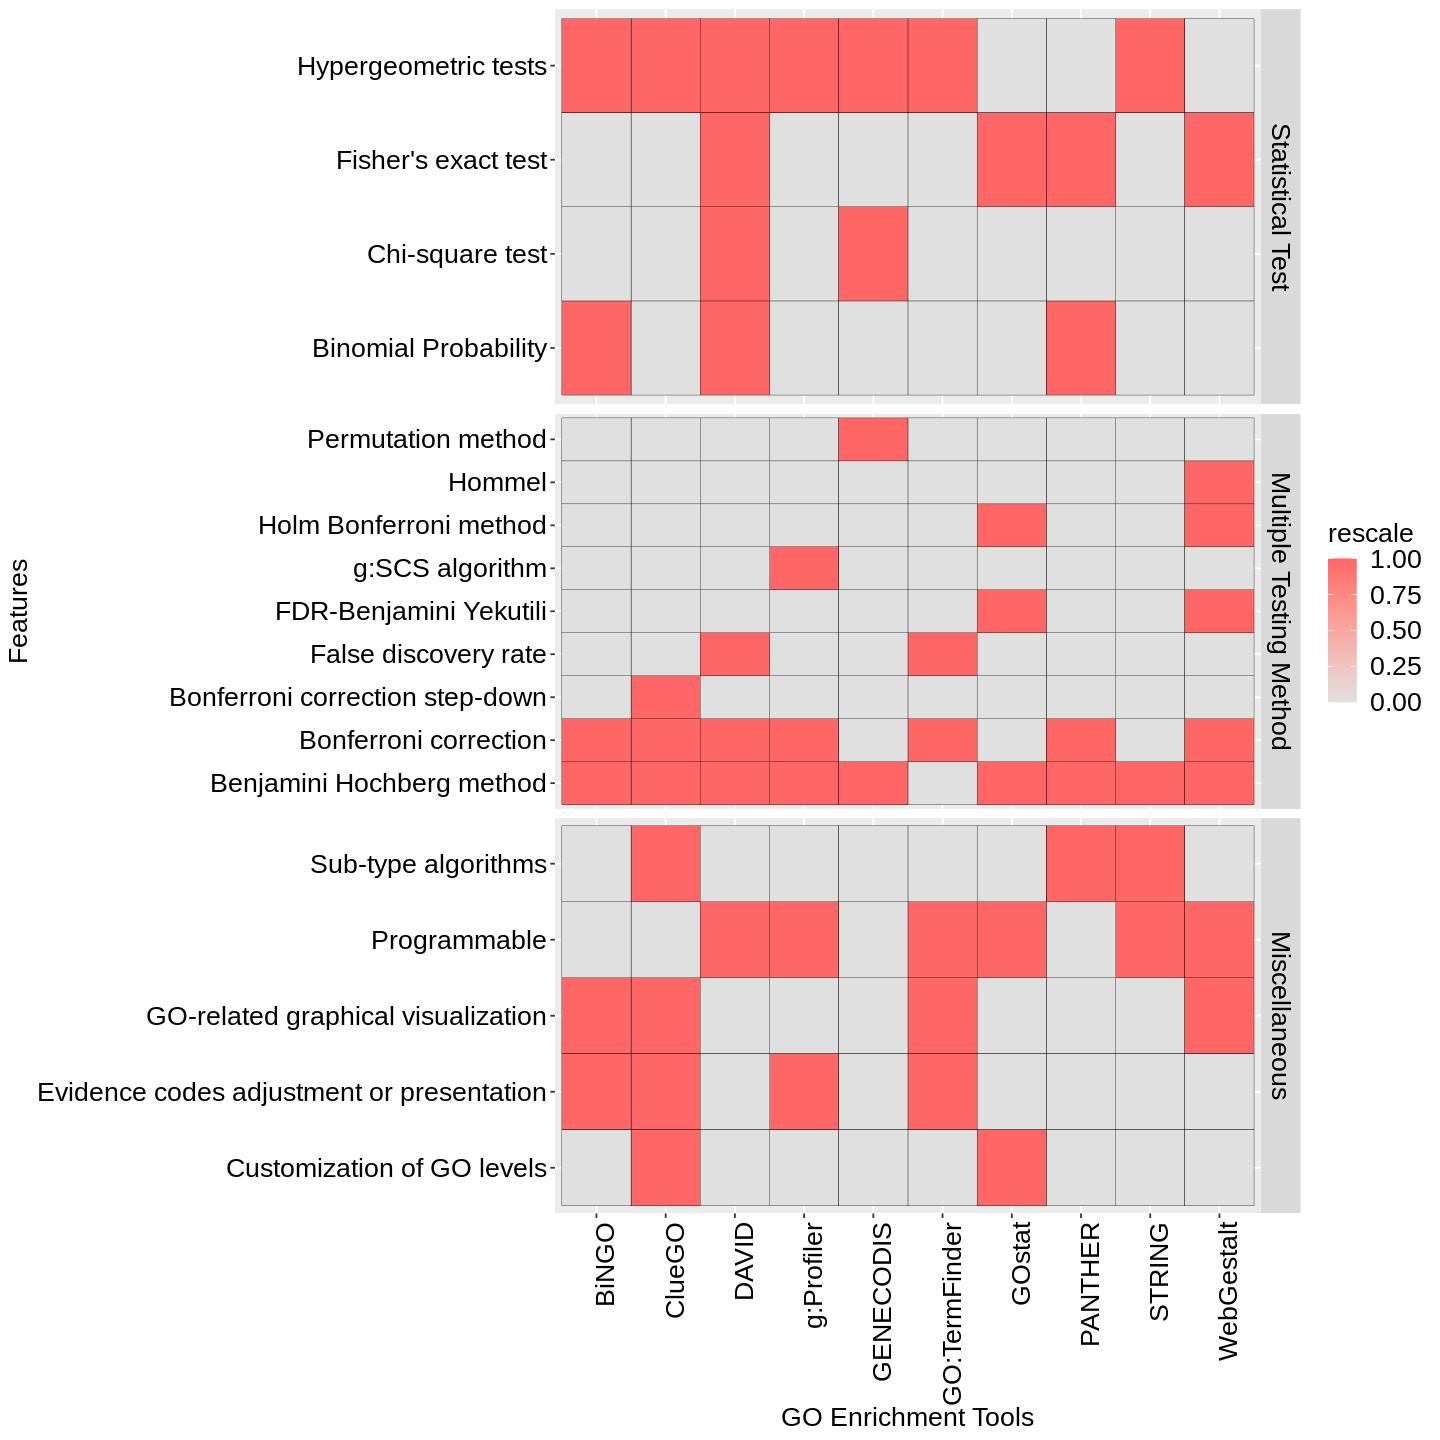

In [ ]:
# Characteristics 
df1.m <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Characteristics.txt")
df1.m$type <- factor(df1.m$type, levels = c("Statistical Test","Multiple Testing Method","Miscellaneous"))
# Make plots wider 
options(repr.plot.width=12, repr.plot.height=12)
ggplot(df1.m, aes(x=Database, y=variable)) +
  geom_tile(aes(fill = rescale), colour = "black") +
  scale_fill_gradient(low = "#E0E0E0", high = "#FF6666") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(colors = "") +theme(axis.text=element_text(size=12)) +
  ylab("Features") +
  xlab("GO Enrichment Tools") +
  facet_grid(type ~ .,scales = "free") + font_custom

## K-mean clustering

,Binomial Probability,Chi-square test,Hypergeometric tests,Fisher's exact test,Permutation method,Benjamini–Hochberg method,Holm–Bonferroni method,False discovery rate,Hommel,FDR-Benjamini Yekutili,Bonferroni correction,Bonferroni correction step-down,g:SCS algorithm,GO-related graphical visualization,Evidence codes adjustment or presentation,Programmable,Sub-type algorithms,Customization of GO levels
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
g:Profiler,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0
GO:TermFinder,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0
ClueGO,0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,0,1,1
BiNGO,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0
STRING,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
DAVID,1,1,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0
PANTHER,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
GENECODIS,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
GOstat,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,1


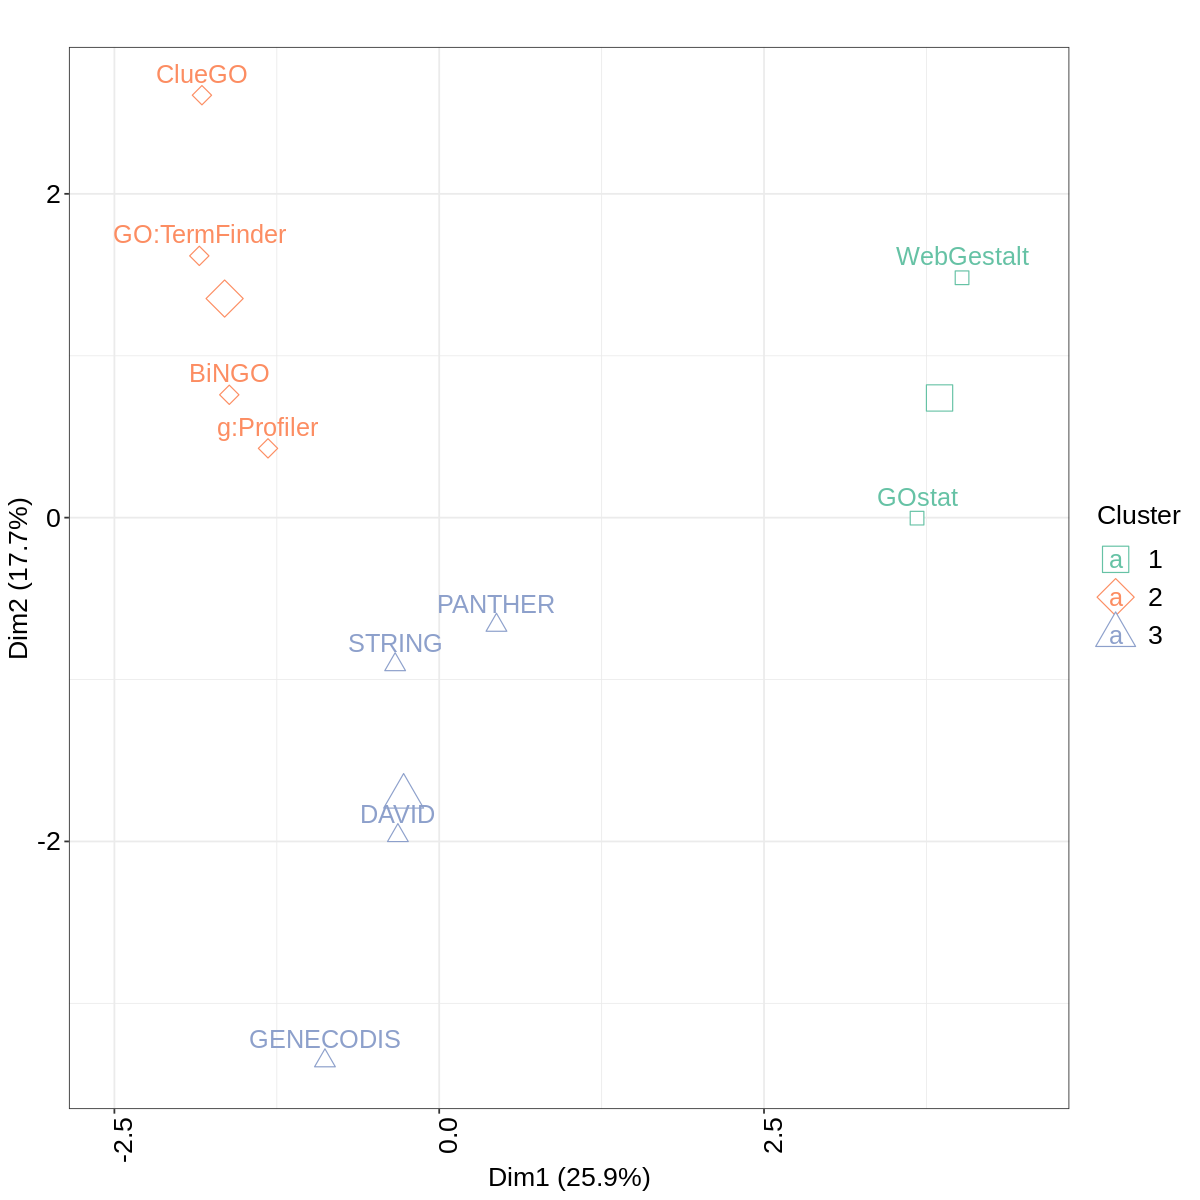

In [ ]:
set.seed(123)
kdf <-  fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Tools_Properties_Binary.csv") %>% as.data.frame()
df.01 <- kdf[,-1]
rownames(df.01) <- kdf[,1]
# function to compute total within-cluster sum of square 
wss <- function(k) {
  kmeans(df, k, nstart = 20 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:8

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

#plot(k.values, wss_values,
#     type="b", pch = 19, frame = FALSE, 
#    xlab="Number of clusters K",
#    ylab="Total within-clusters sum of squares")


final <- kmeans(df.01, 3, nstart = 50,iter.max = 100)

# Make plots wider 
options(repr.plot.width=10, repr.plot.height=10)
fviz_cluster(final, data = df.01,labelsize = 16,ellipse = F,show.clust.cent = T,
pointsize = 4,ggtheme = theme_bw()) +
  theme_bw() +
  xlim(-2.5,4.5)  +
  scale_color_brewer('Cluster', palette='Set2') + 
  scale_fill_brewer('Cluster', palette='Set2') +
  scale_shape_manual('Cluster', values=c(22,23,24)) + 
  ggtitle(label='')+font_custom

# **The proportion of identified GO term in three categories**


## summary of GO term Frequency

In [11]:
df_01 <- read.csv("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt",sep="\t")
head(df_01)

,gene,id,fdr,ref,des,type,dataset,database,condition
,<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,YWHAG,GO:0008426,0.00475653,18483,protein kinase C inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
2,HSPB1,GO:0008426,0.00475653,18483,protein kinase C inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
3,GPI,GO:0004347,0.04792210,18483,glucose-6-phosphate isomerase activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
4,UBE2I,GO:0061656,0.04792210,18483,SUMO conjugating enzyme activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
5,CAV1,GO:0070320,0.04792210,18483,inward rectifier potassium channel inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
6,CCT8,GO:1904851,0.04075850,18883,positive regulation of establishment of protein localization to telomere,Biological Process,Caffeine Dataset,GENECODIS,Unique


In [12]:
count_02 <-df_01[,-1] %>% unique() %>% group_by(database,dataset,type) %>% dplyr::summarise(count=n()) %>% as.data.frame() 
resh <- reshape(count_02, idvar = c("database","dataset"), timevar = "type", direction = "wide")
names(resh) <- c("database","dataset","Biological Process","Cellular Component","Molecular Function")
resh.02 <- resh %>% melt()
resh.03 <- cbind(resh.02 %>% filter(dataset == "Caffeine Dataset"),resh.02 %>% filter(dataset == "EGCG Dataset"))
resh.04 <- resh.03[,c(1,2,3,4,8)]
names(resh.04) <- c("database","dataset","type","Caffeine","EGCG")
resh.04$cat <- "Freq"
GO_freq <- resh.04[,-2]
GO_freq

`summarise()` regrouping output by 'database', 'dataset' (override with `.groups` argument)

Using database, dataset as id variables



database,type,Caffeine,EGCG,cat
<fct>,<fct>,<int>,<int>,<chr>
BiNGO,Biological Process,55,56,Freq
ClueGO,Biological Process,56,76,Freq
DAVID,Biological Process,9,99,Freq
g:Profiler,Biological Process,73,64,Freq
GENECODIS,Biological Process,52,74,Freq
GO::TERMFINDER,Biological Process,85,75,Freq
GOstat,Biological Process,106,137,Freq
PANTHER,Biological Process,187,209,Freq
STRING,Biological Process,135,141,Freq


## Variation Within Dataset

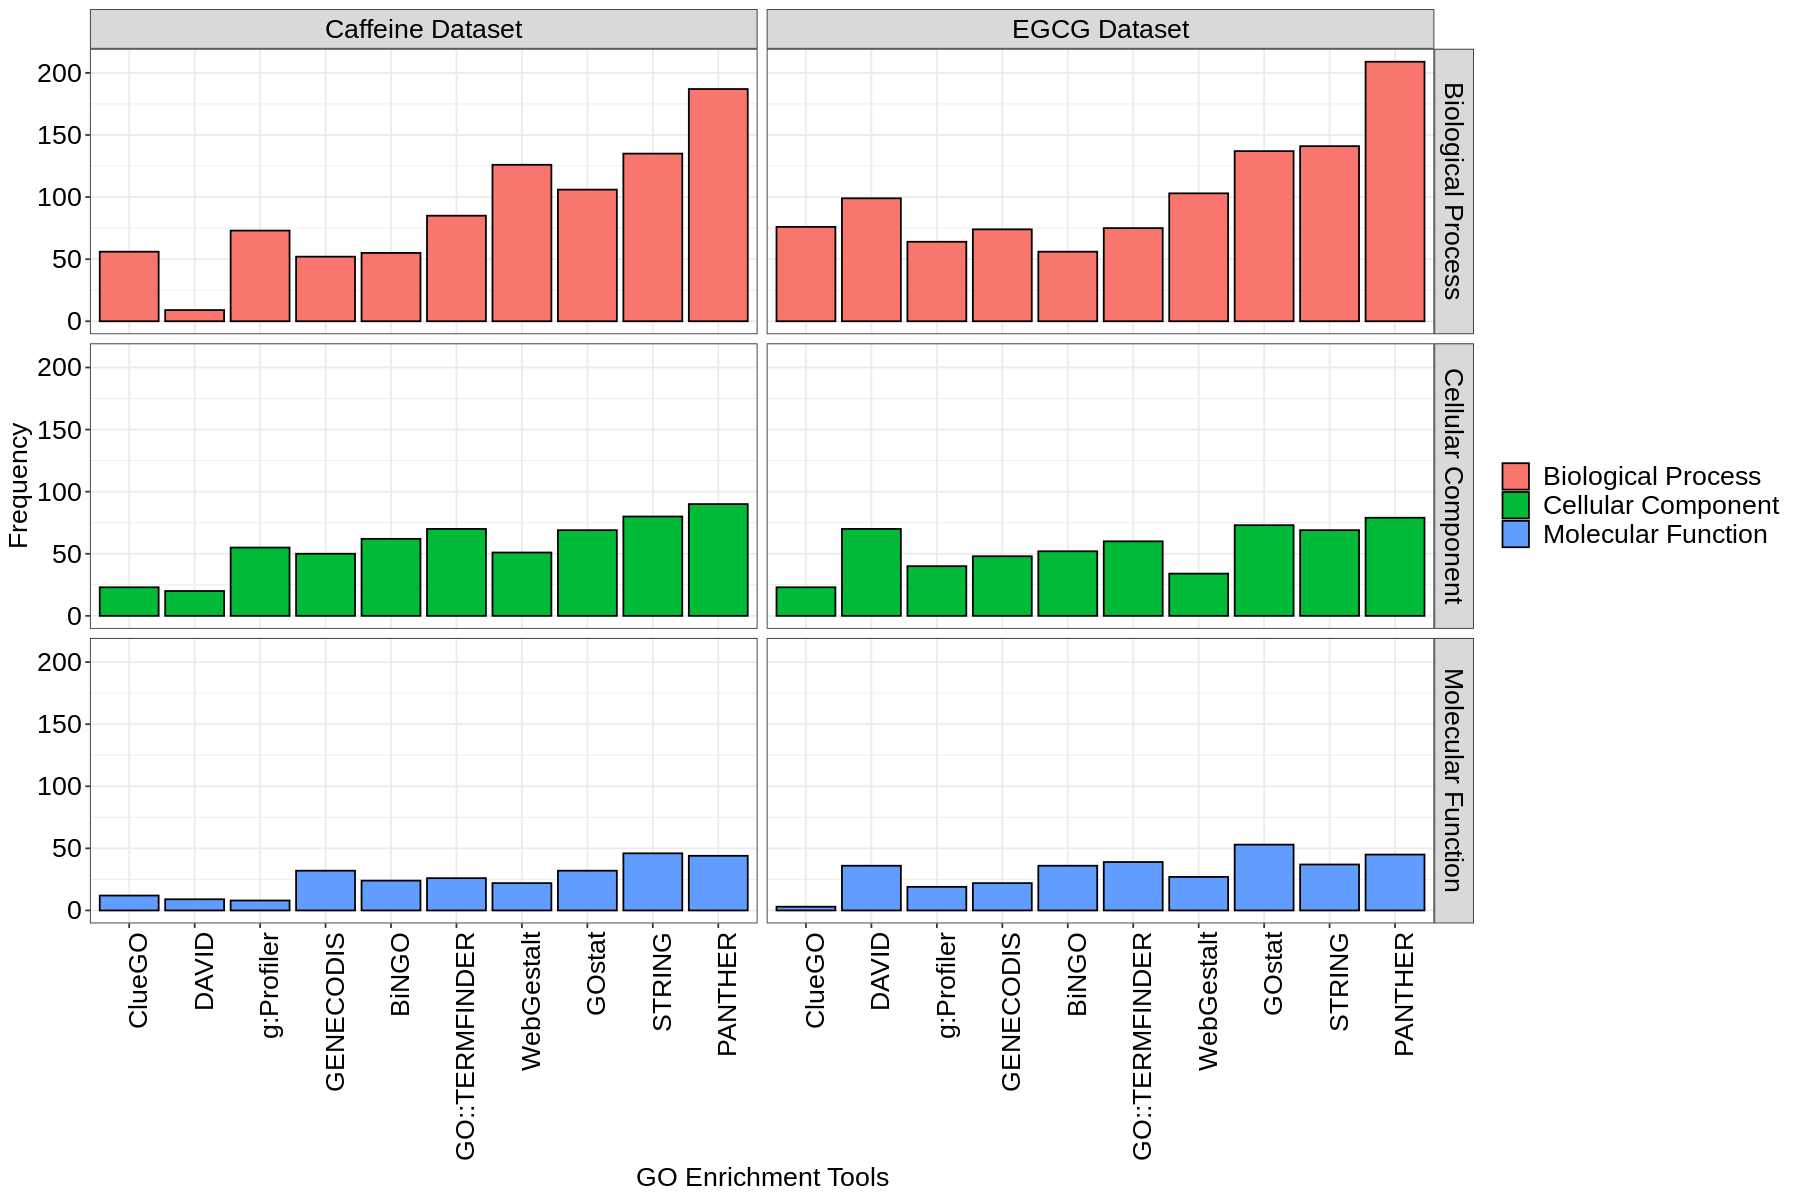

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
 
ggplot(count_02,aes(x=reorder(database,count), y=count,fill=type)) +
  geom_bar(stat="identity", color="black", position=position_dodge()) +
  theme_bw() +
  facet_grid(cols=vars(dataset),rows=vars(type)) +
  labs(fill = "") +
  xlab("GO Enrichment Tools") +
  ylab("Frequency") +
  scale_fill_discrete(name = "", labels = c("Biological Process",
                                                "Cellular Component",
                                                "Molecular Function")) +
                                                font_custom

#### Chi-square Test

In [ ]:
for (i in unique(df_01$dataset) %>% unlist()) {
  print(i)
  Chi_squre_within <- df_01[,c(2,6,7,8)] %>% unique
  Chi_squre_within.02 <- Chi_squre_within %>% filter(.,dataset == i) %>% select(-dataset,-id) 
  Chi_squre_within.03 <- table(Chi_squre_within.02$database,Chi_squre_within.02$type)
  Chi_squre_within.04 <- chisq.test(Chi_squre_within.03)  
  print(Chi_squre_within.04$statistic)
  print(Chi_squre_within.04$p.value)}



[1] "Caffeine Dataset"
X-squared 
 67.64998 
[1] 1.124195e-07
[1] "EGCG Dataset"
X-squared 
 68.89196 
[1] 6.95257e-08


##### Heatmap For Pairwise Comparison

In [ ]:
pairs_wise <- function(k){
  Chi_squre_within <- df_01[,c(2,6,7,8)] %>% unique
  Chi_squre_within.02 <- Chi_squre_within %>% filter(.,dataset == k) %>% select(-dataset,-id) 
  x.02 <- table(Chi_squre_within.02$type,Chi_squre_within.02$database) %>% as.data.frame()  
  x.03 <- reshape(x.02, idvar = "Var1", timevar = "Var2", direction = "wide")
  x.04 <- x.03[,-1]
  rownames(x.04) <- x.03[,1]
  x.02 <- x.04
  names(x.02) <- c("BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
  # initialization
  out_list <- list()
  column <- 1
  # cycle for storing kappa2's output structure
  for (i in 1:(ncol(x.02)-1)){
   for (j in (i+1):ncol(x.02)){
      x <- chisq.test(x.02[,c(i,j)])
      out_list[[column]] <- x$p.value
      # renaming the elements
      names(out_list)[column] <- paste0(colnames(x.02[i]), "_", colnames(x.02[j]))
      column <- column + 1
    }
  }

  res <- do.call(rbind,out_list) %>% as.data.frame()
  res$data <- rownames(res.eg)
  res.1 <- splitstackshape::cSplit(res.eg, "data", "_")
  res.1$type <- k

  p.adj <- p.adjust(unlist(res.1[,1]), method = "fdr")
  res.1$adj <- as.data.frame(p.adj)
  return(res.1)
}


In [ ]:
res.caf <- pairs_wise("Caffeine Dataset")
res.egcg <- pairs_wise("EGCG Dataset")

res.all <- rbind(res.caf,res.egcg)
res.all$data_2 <- gsub(".[0-9]", "", res.all$data_2)

res.all$sig <- ifelse(res.all$adj < 0.001,"***",
                      ifelse(res.all$adj < 0.01,"**",
                             ifelse(res.all$adj < 0.05,"*","ns")))

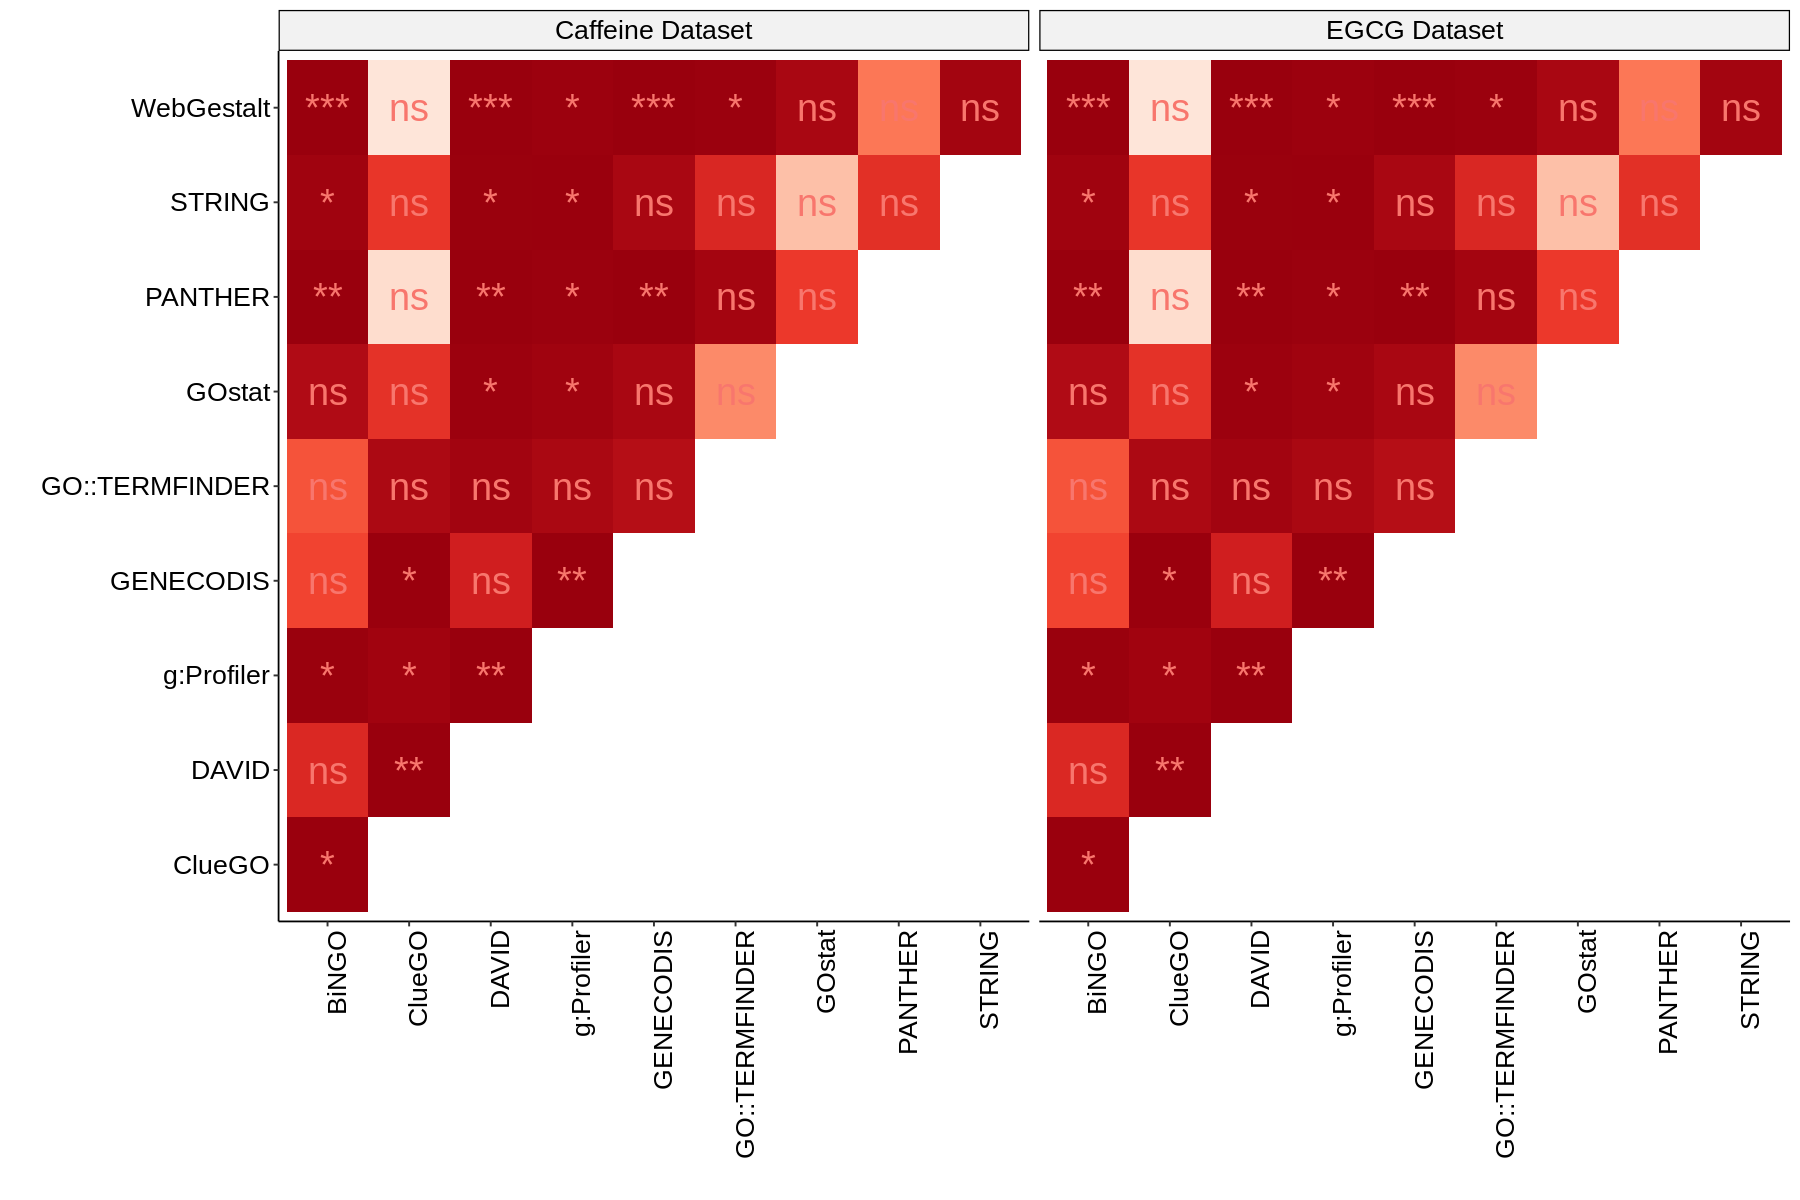

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data = res.all, aes(x = data_1, y = data_2)) +
  geom_tile(aes(fill=V1))+
  facet_grid(cols=vars(type)) + 
  theme_pubr() +
  geom_text(aes(label=sig,color="white"),cex=8)+
  theme(legend.position="none") +
  scale_fill_distiller(palette = "Reds") +
  xlab("") +
  ylab("") + font_custom

`summarise()` regrouping output by 'database', 'dataset', 'ref' (override with `.groups` argument)

`geom_smooth()` using formula 'y ~ x'



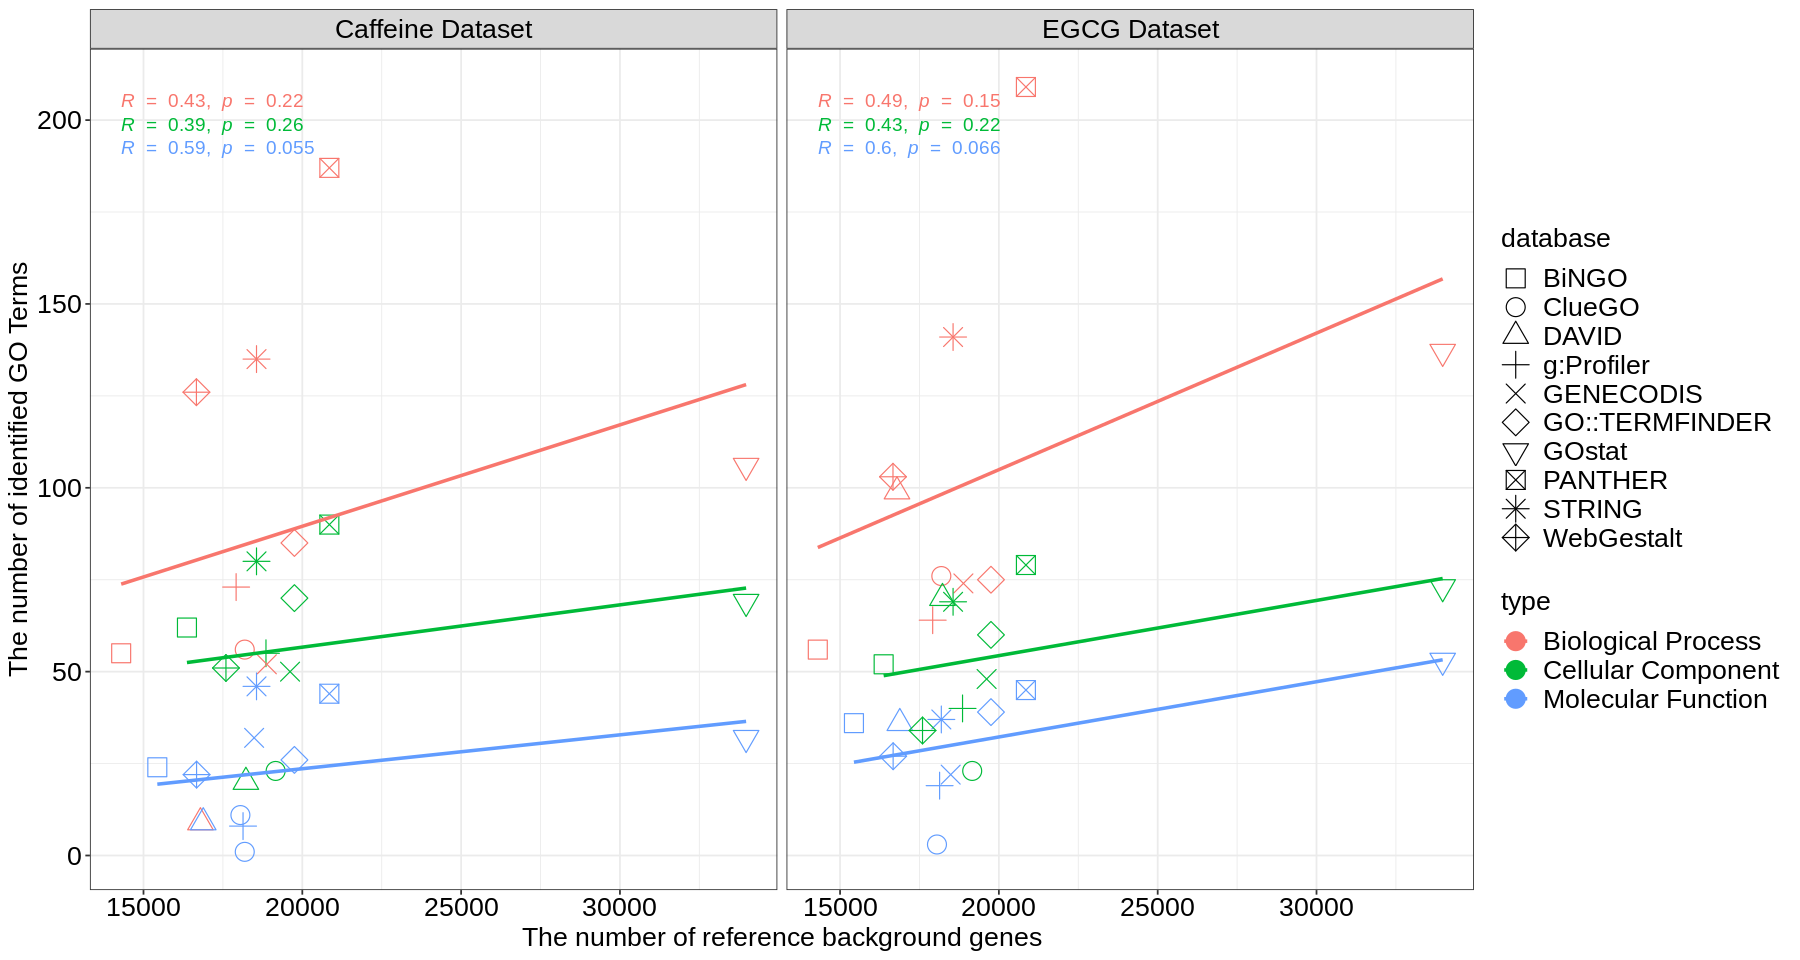

In [ ]:
df.02 <- df_01[with(df_01, order(database,dataset)), ] %>% select(-gene) %>% unique() %>% group_by(database,dataset,ref,type) %>% 
  dplyr::summarise(CNT=n()) %>% as.data.frame() 

options(repr.plot.width=15, repr.plot.height=8)
ggplot(df.02,aes(ref,CNT,color=type)) +
  geom_point(aes(shape=database),size=5) + 
  scale_shape_manual(values=seq(0,10)) +
  facet_grid(cols=vars(dataset))  +
  theme_bw() +
 stat_cor(method="spearman",size = 4) +
  xlab("The number of reference background genes") +
  ylab("The number of identified GO Terms")+ font_custom.02+ 
  geom_smooth(method='lm', se = FALSE)


New names:
* database -> database...1
* dataset -> dataset...2
* type -> type...3
* count -> count...4
* database -> database...5
* ...



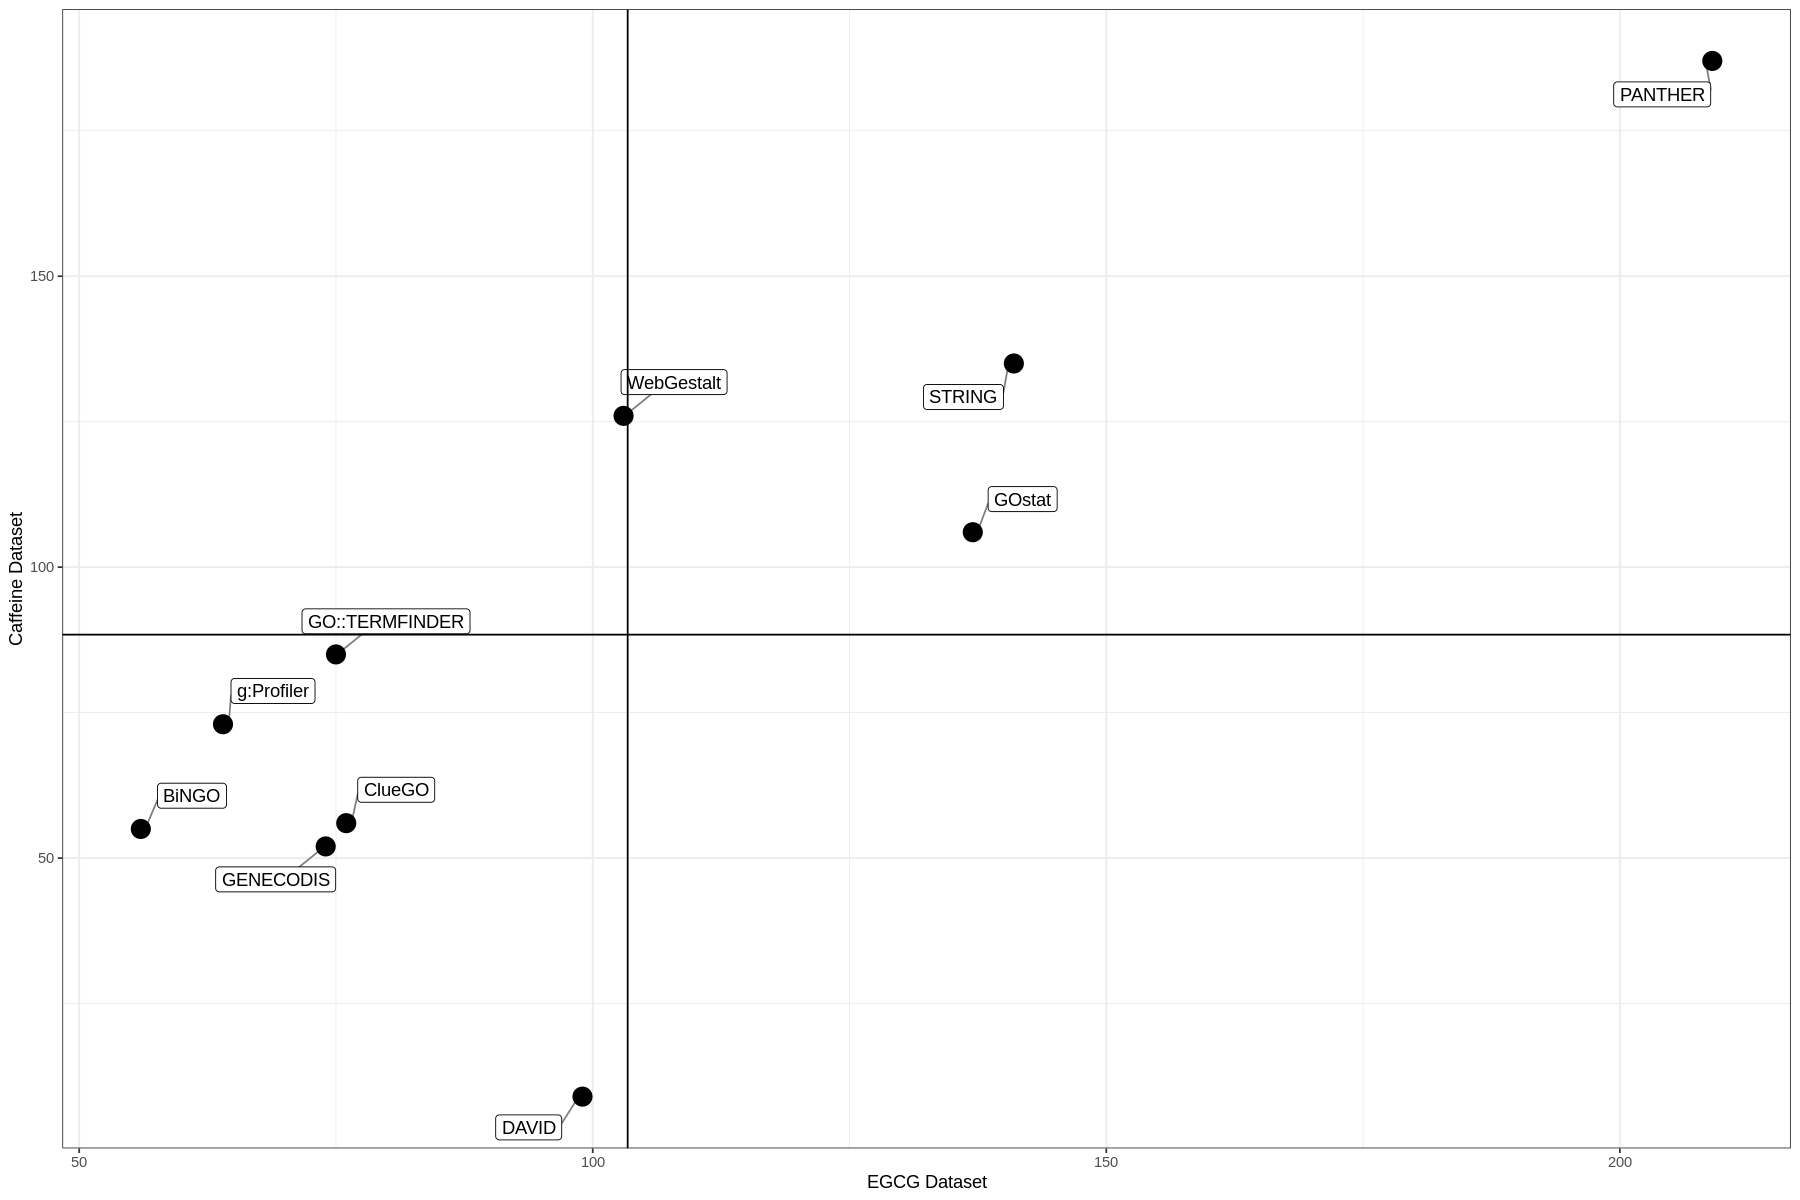

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
count_02_egcg <- count_02 %>% filter(dataset == "EGCG Dataset")
count_02_caf <- count_02 %>% filter(dataset == "Caffeine Dataset")
cor_cat <- bind_cols(count_02_egcg,count_02_caf)
cor_cat_02 <- cor_cat[,-c(2,5:7)]
names(cor_cat_02) <- c("GO Enrichment Database","Type","EGCG Dataset","Caffeine Dataset")


plot_scatter <- function(i){
  BP_me <- cor_cat_02 %>% filter(Type == i)
  cor_cat_02 %>% filter(Type == i) %>%
  ggplot( aes(x= `EGCG Dataset`, y= `Caffeine Dataset`))+
  geom_label_repel(aes(label = `GO Enrichment Database`),
                   box.padding   = 0.35, 
                   point.padding = 0.5,
                   segment.color = 'grey50') +
  geom_point(size=5) +
  theme_bw() + geom_vline(xintercept=mean(BP_me$`EGCG Dataset`)) + geom_hline(yintercept=mean(BP_me$`Caffeine Dataset`))
}

plot_scatter("Biological Process")

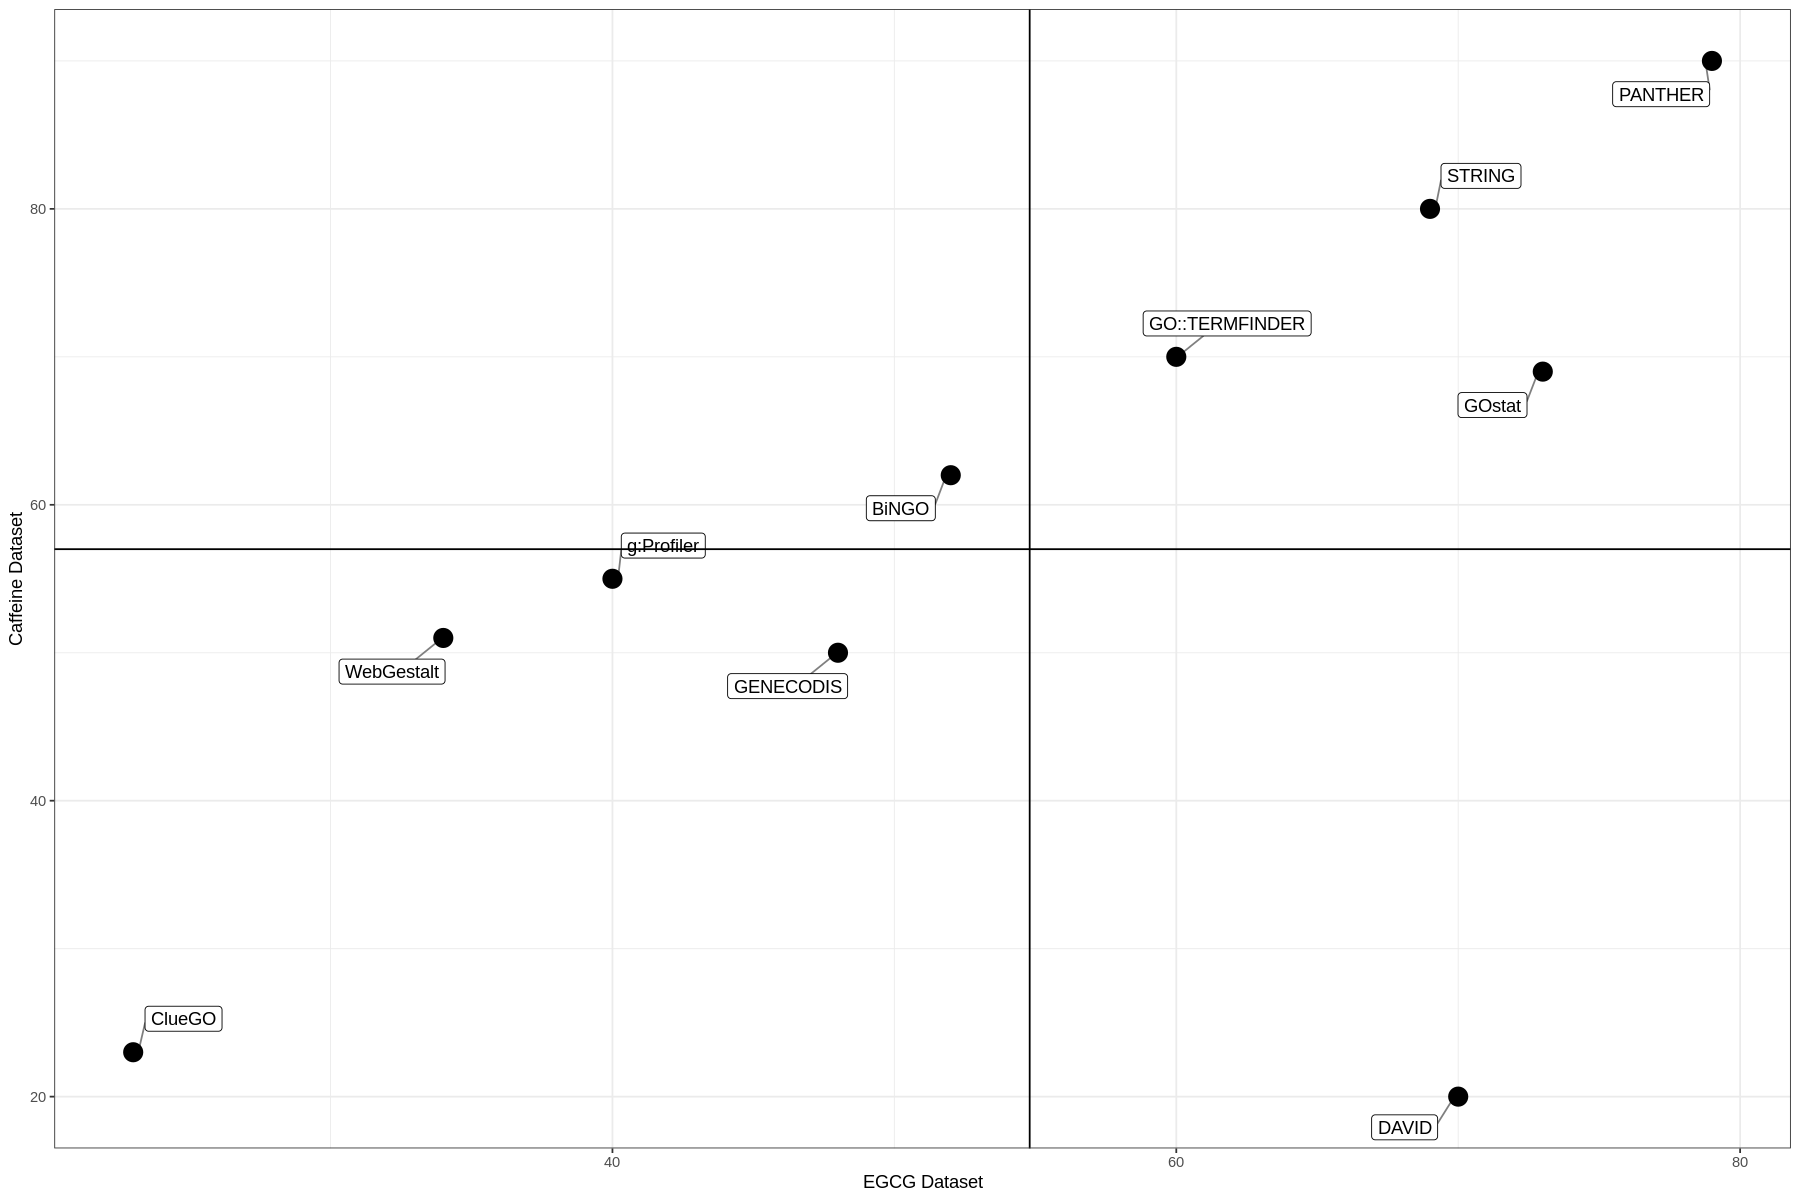

In [ ]:
plot_scatter("Cellular Component")


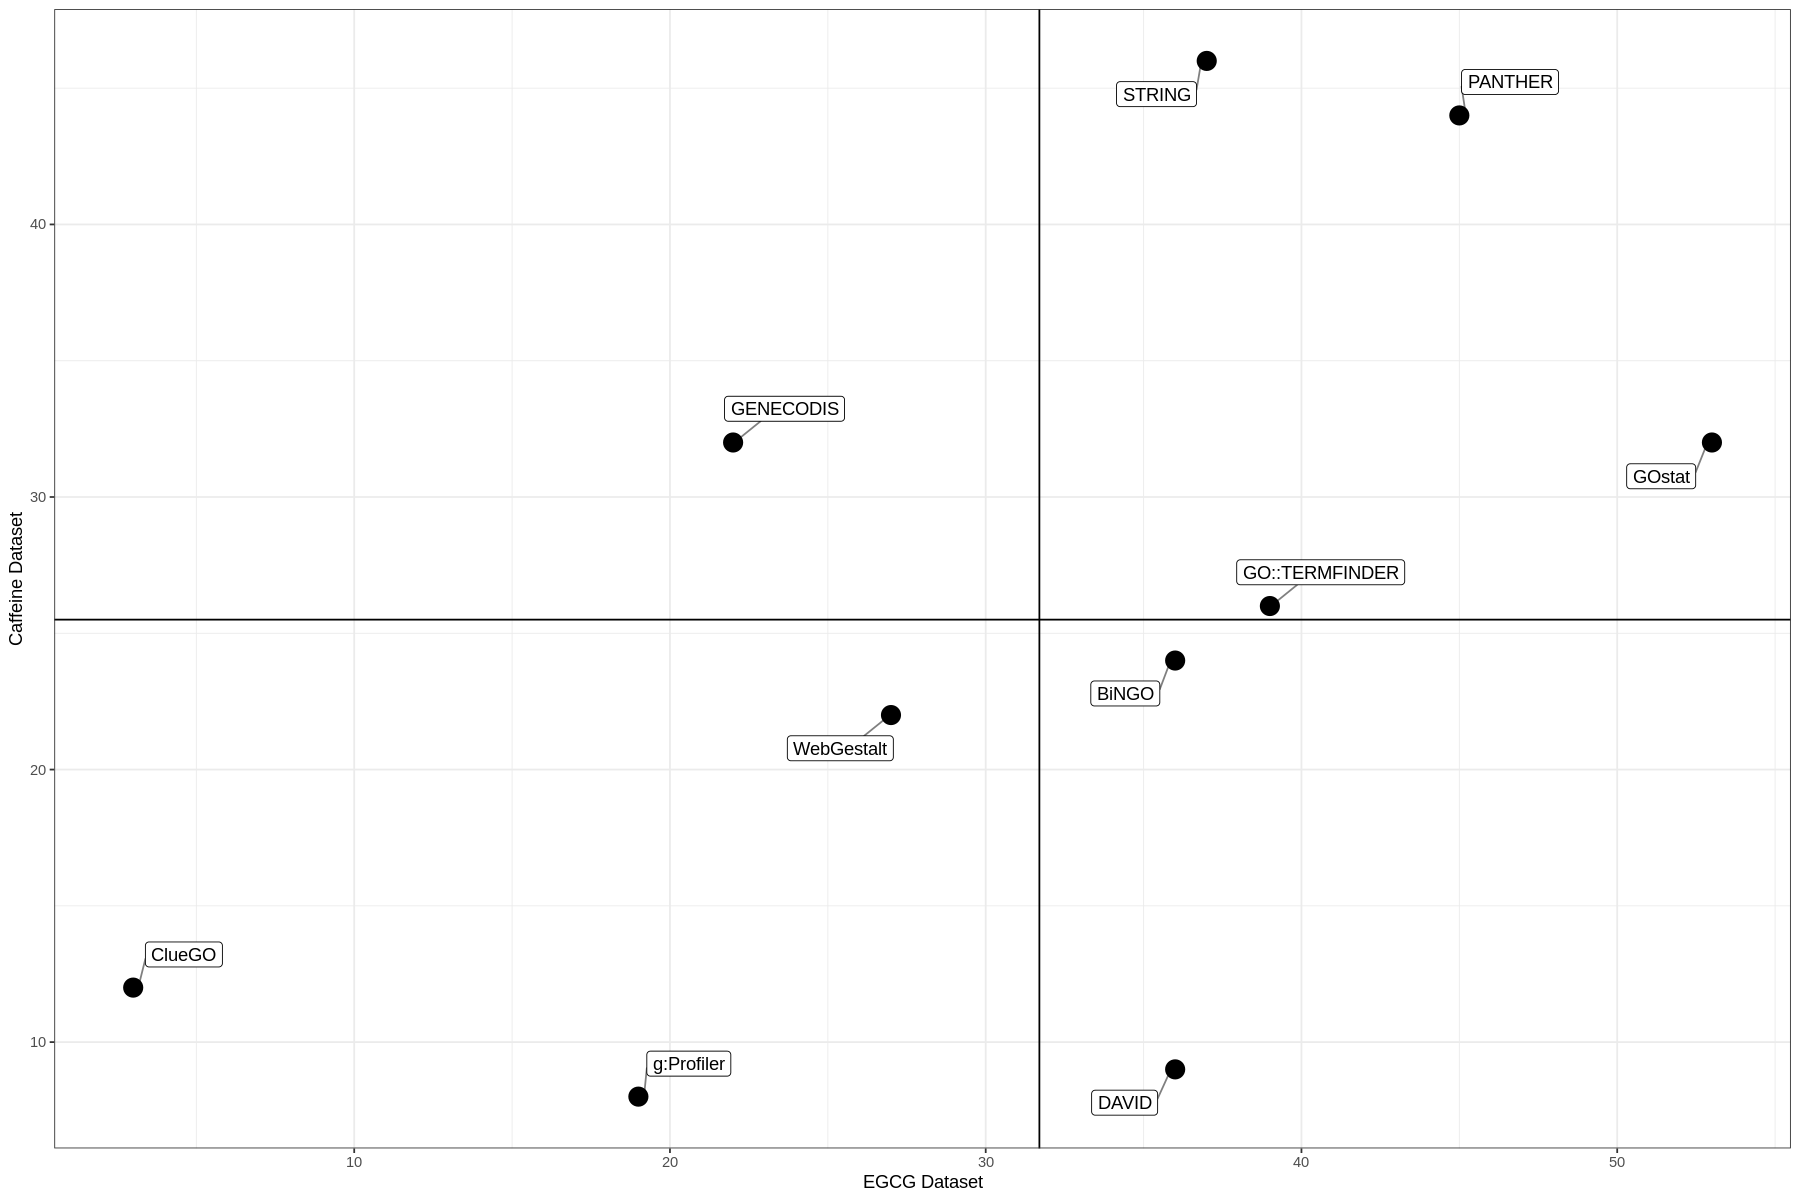

In [ ]:
plot_scatter("Molecular Function")

# **The comparison of the number of annotated gene**

## summary of GO term Frequency

In [13]:
df_j <- df_01 %>% select(gene,dataset,database,type) %>% unique() %>% group_by(dataset,database,type) %>% summarise(CNT=n()) 
df_j$con <- "Remaining genes"
df_j.02 <- cbind(df_j %>% filter(dataset=="Caffeine Dataset"),
      df_j %>% filter(dataset=="EGCG Dataset"))

df_j.03 <- df_j.02[,-c(1,5,6,7,8,10)]
names(df_j.03) <- c("database","type","Caffeine","EGCG")
df_j.03$cat <- "Annotated Gene"
annotate_gene <- df_j.03
annotate_gene

`summarise()` regrouping output by 'dataset', 'database' (override with `.groups` argument)

New names:
* dataset -> dataset...1
* database -> database...2
* type -> type...3
* CNT -> CNT...4
* con -> con...5
* ...



database,type,Caffeine,EGCG,cat
<fct>,<fct>,<int>,<int>,<chr>
BiNGO,Biological Process,104,109,Annotated Gene
BiNGO,Cellular Component,114,126,Annotated Gene
BiNGO,Molecular Function,115,126,Annotated Gene
ClueGO,Biological Process,75,85,Annotated Gene
ClueGO,Cellular Component,61,64,Annotated Gene
ClueGO,Molecular Function,30,18,Annotated Gene
DAVID,Biological Process,38,127,Annotated Gene
DAVID,Cellular Component,117,136,Annotated Gene
DAVID,Molecular Function,101,128,Annotated Gene


# **The comparison of common vs. unique identified GO terms in the current and previous study**







## summary of GO term uniquess

In [14]:
uniq_df <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() 
list_df <- table(uniq_df$id) %>% melt() %>% filter(value==1) %>% select(Var1) %>% unlist() 

uniqueness_df <- uniq_df %>% filter(id %in% list_df) %>% group_by(dataset,database,type) %>% summarise(CNT=n()) %>% as.data.frame() %>%
      add_row(database = c("BiNGO","ClueGO","GO::TERMFINDER","GO::TERMFINDER","WebGestalt","g:Profiler","g:Profiler","g:Profiler","DAVID","DAVID","DAVID"),
                   CNT = c(0,0,0,0,0,0,0,0,0,0,0),
                   dataset = c("Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset","Caffeine Dataset"),
                  type = c("Molecular Function","Cellular Component","Molecular Function","Cellular Component","Cellular Component","Molecular Function","Cellular Component",
                  "Biological Process","Molecular Function","Cellular Component","Biological Process")) %>%
      add_row(database = c("BiNGO","DAVID","PANTHER","PANTHER","STRING","WebGestalt","WebGestalt","ClueGO","ClueGO","g:Profiler","g:Profiler","g:Profiler",
      "GO::TERMFINDER","GO::TERMFINDER","GO::TERMFINDER"),
                   CNT = c(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),
                   dataset = c("EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset",
                   "EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset","EGCG Dataset"),
                  type = c("Molecular Function","Cellular Component","Molecular Function","Cellular Component",
                  "Cellular Component","Molecular Function","Cellular Component","Molecular Function","Cellular Component","Molecular Function","Cellular Component",
                  "Biological Process","Molecular Function","Cellular Component","Biological Process"))
uniqueness_df_caf <- uniqueness_df %>% filter(dataset == "Caffeine Dataset")
uniqueness_df_caf_02 <- uniqueness_df_caf[order(uniqueness_df_caf$database),]
uniqueness_df_egcg <- uniqueness_df %>% filter(dataset == "EGCG Dataset")
uniqueness_df_egcg_02 <- uniqueness_df_egcg[order(uniqueness_df_egcg$database),]

uniquesness_all <- cbind(uniqueness_df_egcg_02,uniqueness_df_caf_02)
uniquesness_all_02 <- uniquesness_all[,-c(3,5,6)]
names(uniquesness_all_02) <- c("dataset","database","EGCG","type","Caffeine")
uniquesness_all_02$cat <- "Uniquess"
uniqueness_GO <- uniquesness_all_02[,-1]
uniqueness_GO


`summarise()` regrouping output by 'dataset', 'database' (override with `.groups` argument)



,database,EGCG,type,Caffeine,cat
,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,BiNGO,1,Biological Process,8,Uniquess
2,BiNGO,1,Cellular Component,1,Uniquess
16,BiNGO,0,Molecular Function,0,Uniquess
3,ClueGO,6,Biological Process,7,Uniquess
23,ClueGO,0,Molecular Function,5,Uniquess
24,ClueGO,0,Cellular Component,0,Uniquess
4,DAVID,8,Molecular Function,0,Uniquess
5,DAVID,2,Cellular Component,0,Uniquess
17,DAVID,0,Biological Process,0,Uniquess


### Uniquess Visualization

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



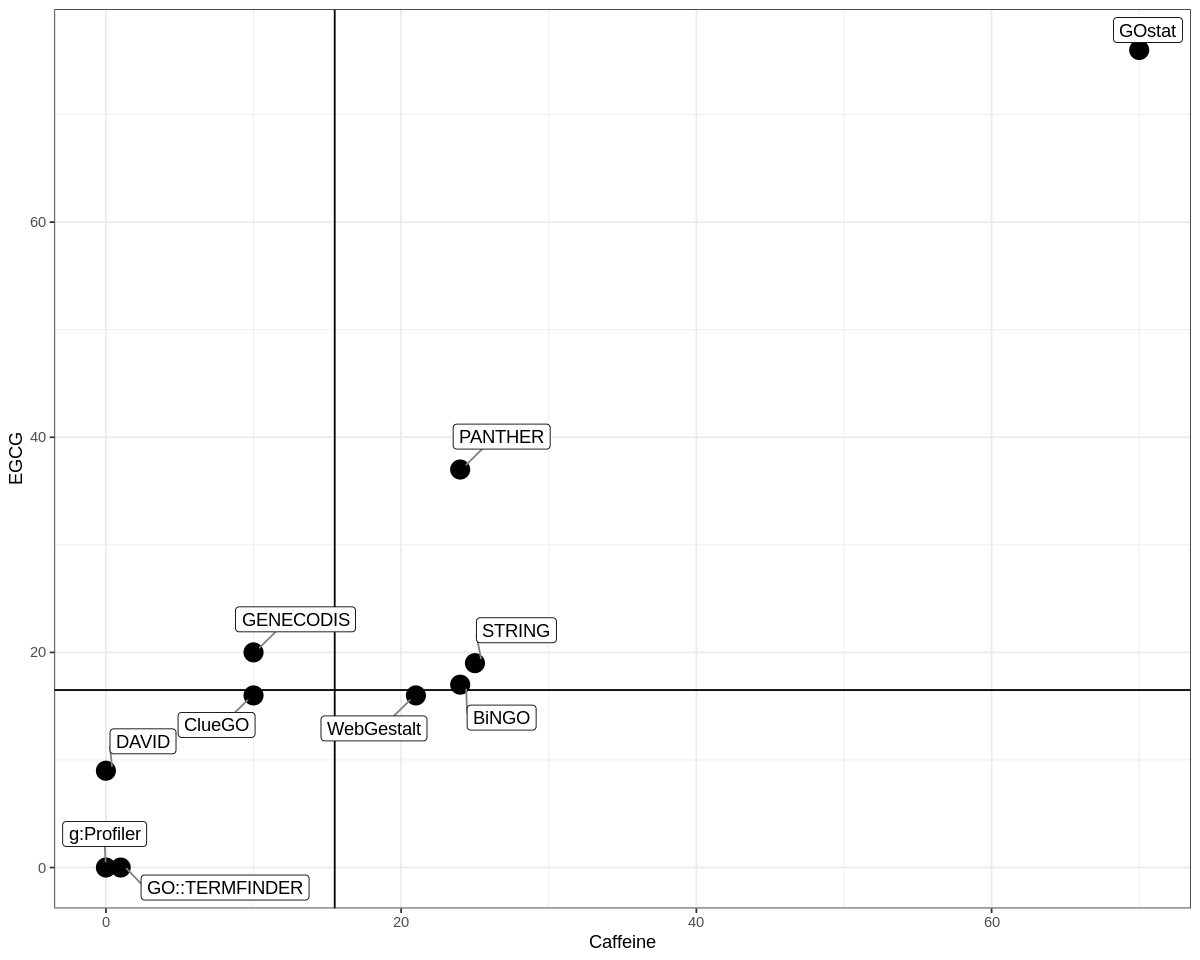

In [ ]:
gather_res <- function(j,k){
  pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
  dplyr::select(-gene) %>% unique() %>% filter(dataset == j) %>% filter(type == k) 
  df_list <- table(pca_new$id) %>% melt() %>% filter(value==1) %>% select(Var1) %>% unlist()
  pca_res <- pca_new %>% filter(id %in% df_list) %>% group_by(database) %>% summarise(CNT=n())
  pca_res$dataset <- j
  pca_res$type <- k
  return(pca_res)
} 

Caf_BP <- gather_res("Caffeine Dataset","Biological Process")
Caf_BP_02 <- Caf_BP %>% add_row(database = c("g:Profiler","DAVID"), CNT = c(0,0),
                   dataset = c("Caffeine Dataset","Caffeine Dataset"),type = c("Biological Process","Biological Process"))
Caf_BP_03 <- Caf_BP_02[order(Caf_BP_02$database),]


EGCG_BP <- gather_res("EGCG Dataset","Biological Process")

EGCG_BP_02 <- EGCG_BP %>% add_row(database = c("g:Profiler","GO::TERMFINDER"), CNT = c(0,0),
                   dataset = c("EGCG Dataset","EGCG Dataset"),type = c("Biological Process","Biological Process"))
EGCG_BP_03 <- EGCG_BP_02[order(EGCG_BP_02$database),]


all_res <- cbind(Caf_BP_03,EGCG_BP_03) %>% as.data.frame()
all_res_02 <- all_res[,c(1,2,6)]
names(all_res_02) <- c("database","Caffeine","EGCG")
options(repr.plot.width=10, repr.plot.height=8)
ggplot(all_res_02,aes(Caffeine,EGCG)) +
geom_point(size=5) +
geom_hline(yintercept = median(all_res_02$EGCG)) +
geom_vline(xintercept = median(all_res_02$Caffeine))+
  geom_label_repel(aes(label = database),
                   box.padding   = 0.35, 
                   point.padding = 0.5,
                   segment.color = 'grey50') +
                   theme_bw()


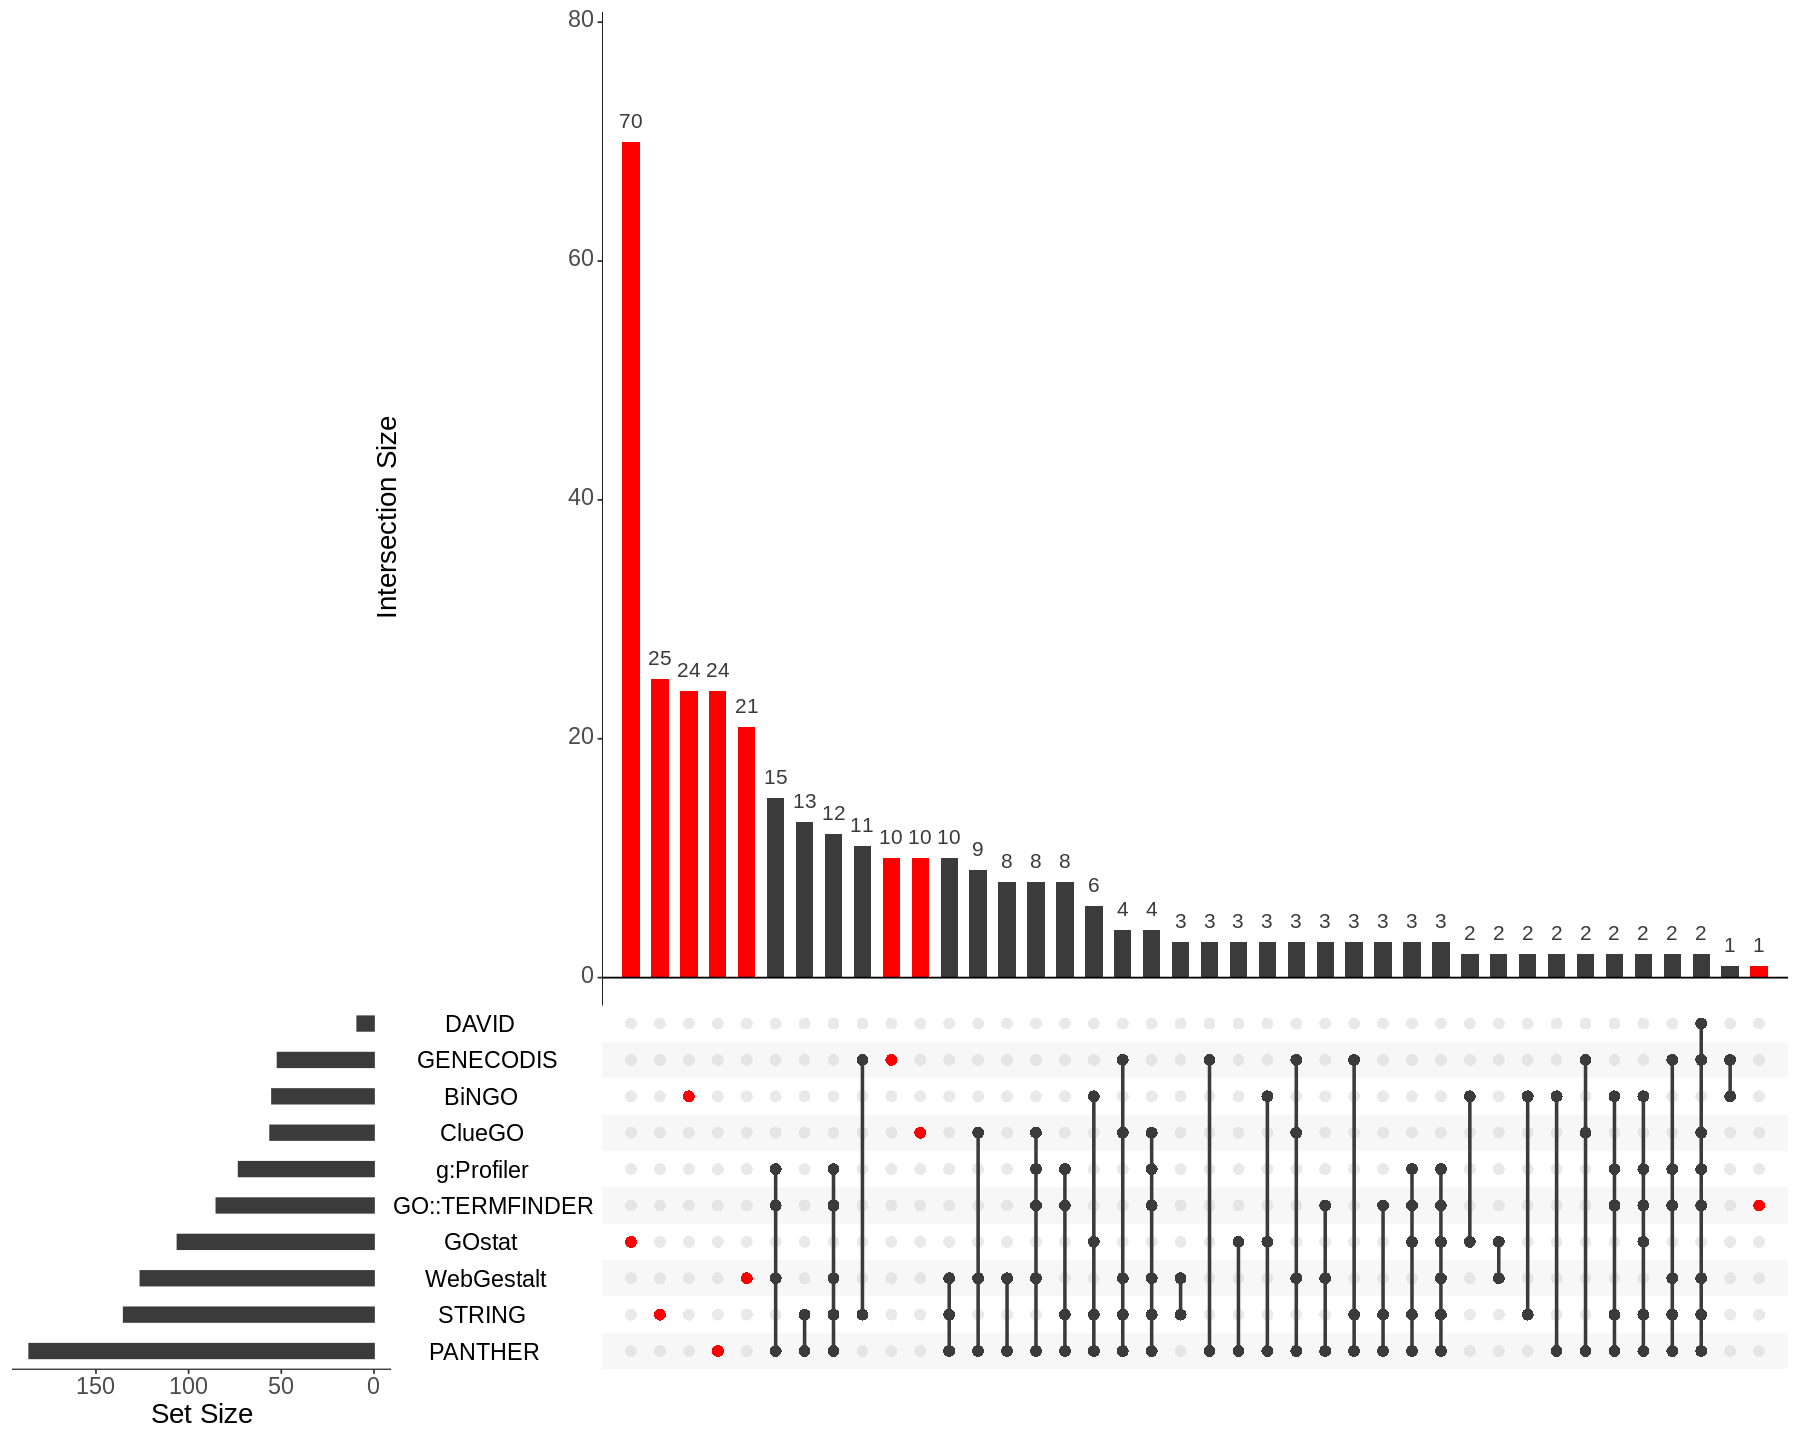

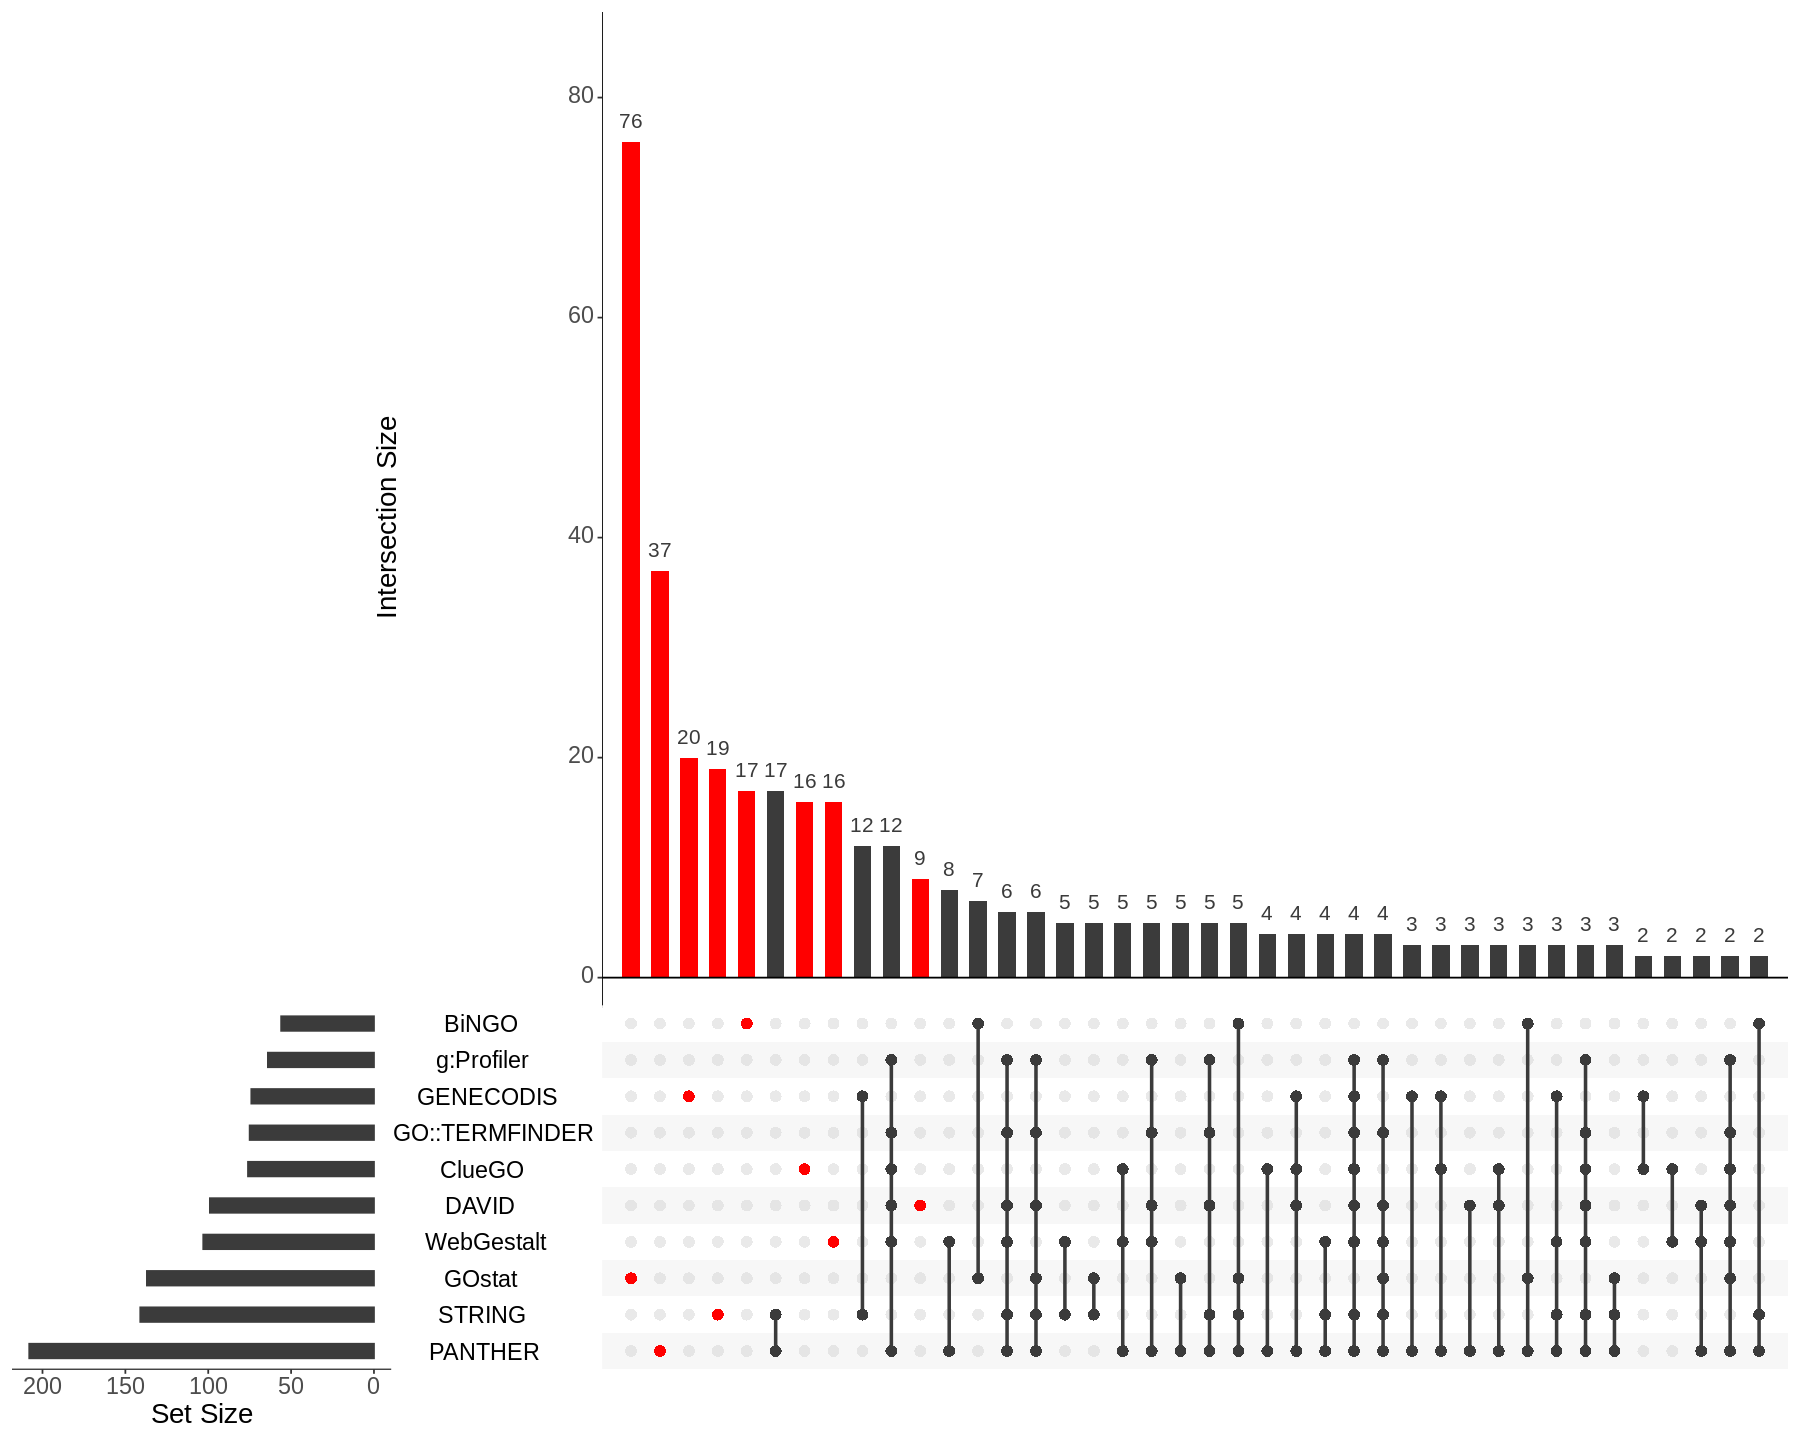

In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "Caffeine Dataset") %>% filter(type == "Biological Process")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")

UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("BiNGO"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("WebGestalt"), active = T,color = "red"),
      list(query = intersects, params = list("ClueGO"), active = T,color = "red"),
      list(query = intersects, params = list("GO::TERMFINDER"), active = T,color = "red")),
      empty.intersections = "on")

pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "EGCG Dataset") %>% filter(type == "Biological Process")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      empty.intersections = "on",
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("BiNGO"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("WebGestalt"), active = T,color = "red"),
      list(query = intersects, params = list("ClueGO"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red")))


In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "EGCG Dataset") %>% filter(type == "Cellular Component")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("BiNGO"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red")))


pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "Caffeine Dataset") %>% filter(type == "Cellular Component")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("BiNGO"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red"),
      list(query = intersects, params = list("GO::TERMFINDER"), active = T,color = "red")))





In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "EGCG Dataset") %>% filter(type == "Molecular Function")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red")))

pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
dplyr::select(-gene) %>% unique() %>% filter(dataset == "Caffeine Dataset") %>% filter(type == "Molecular Function")

pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
pca_new_03_name <- colnames(pca_new_03)[4:13]
UpSetR::upset(pca_new_03, 
      nsets = 10, 
      order.by = "freq", 
       keep.order = TRUE,
      text.scale = 2, 
      point.size = 3, 
      line.size = 1,
      queries = list(list(query = intersects, params = list("STRING"), active = T,color = "red"),
      list(query = intersects, params = list("GENECODIS"), active = T,color = "red"),
      list(query = intersects, params = list("GOstat"), active = T,color = "red"),
      list(query = intersects, params = list("PANTHER"), active = T,color = "red"),
      list(query = intersects, params = list("DAVID"), active = T,color = "red"),
      list(query = intersects, params = list("ClueGO"), active = T,color = "red"),
      list(query = intersects, params = list("WebGestalt"), active = T,color = "red")))


## Variation Within Dataset

In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-gene) %>% unique()  
pca_new_02 <- table(pca_new$database,pca_new$id,pca_new$dataset,pca_new$type) %>% as.data.frame()
pca_new_03 <- reshape(pca_new_02, idvar = c("Var1","Var3","Var4"), timevar = "Var2", direction = "wide")
pca_new_03

In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-gene) %>% unique()  
pca_new_02 <- table(pca_new$database,pca_new$id,pca_new$dataset,pca_new$type) %>% as.data.frame()
pca_new_03 <- reshape(pca_new_02, idvar = c("Var1","Var3","Var4"), timevar = "Var2", direction = "wide")

Kappa_between <- function(database,categories){
  chi <- pca_new_03 %>% filter(Var3 == database, Var4 == categories) %>% select(-Var3,-Var4) 
  chi.01 <- chi[,-1]
  rownames(chi.01) <- chi[,1]
  chi.01[chi.01 > 1]<-1
  ex <-  chi.01 %>% t() %>% as.data.frame()
  out <- as.data.frame(matrix(0, nrow = 1, ncol = ncol(ex) * (ncol(ex)-1) / 2))
  column <- 1

  # cycle for calculation kappa
for (i in 1:(ncol(ex)-1)){
  for (j in (i+1):ncol(ex)){
    out[1,column] <- irr::kappa2(ex[,c(i,j)])$value
    colnames(out)[column] <- paste(colnames(ex[i]), 
                                      "&", colnames(ex[j]))
    column <- column + 1
  }
}
res <- t(out) %>% as.data.frame() 
res$categories <- categories
res$databases <- database
res
}


In [ ]:
EGCG.BP <- Kappa_between("EGCG Dataset","Biological Process")
EGCG.MF <- Kappa_between("EGCG Dataset","Molecular Function")
EGCG.CC <- Kappa_between("EGCG Dataset","Cellular Component")

Caf.BP <- Kappa_between("Caffeine Dataset","Biological Process")
Caf.MF <- Kappa_between("Caffeine Dataset","Molecular Function")
Caf.CC <- Kappa_between("Caffeine Dataset","Cellular Component")

cdf_EGCG_validate <- rbind(EGCG.BP,EGCG.MF,EGCG.CC)
cdf_caffeine_validate <- rbind(Caf.BP,Caf.MF,Caf.CC)
cdf_validate <- cbind(cdf_EGCG_validate,cdf_caffeine_validate)
cdf_validate.02 <- cdf_validate[,-c(2,3,6)] 
names(cdf_validate.02) <- c("EGCG","Caffeine","Categories")

Using Categories, con_02 as id variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



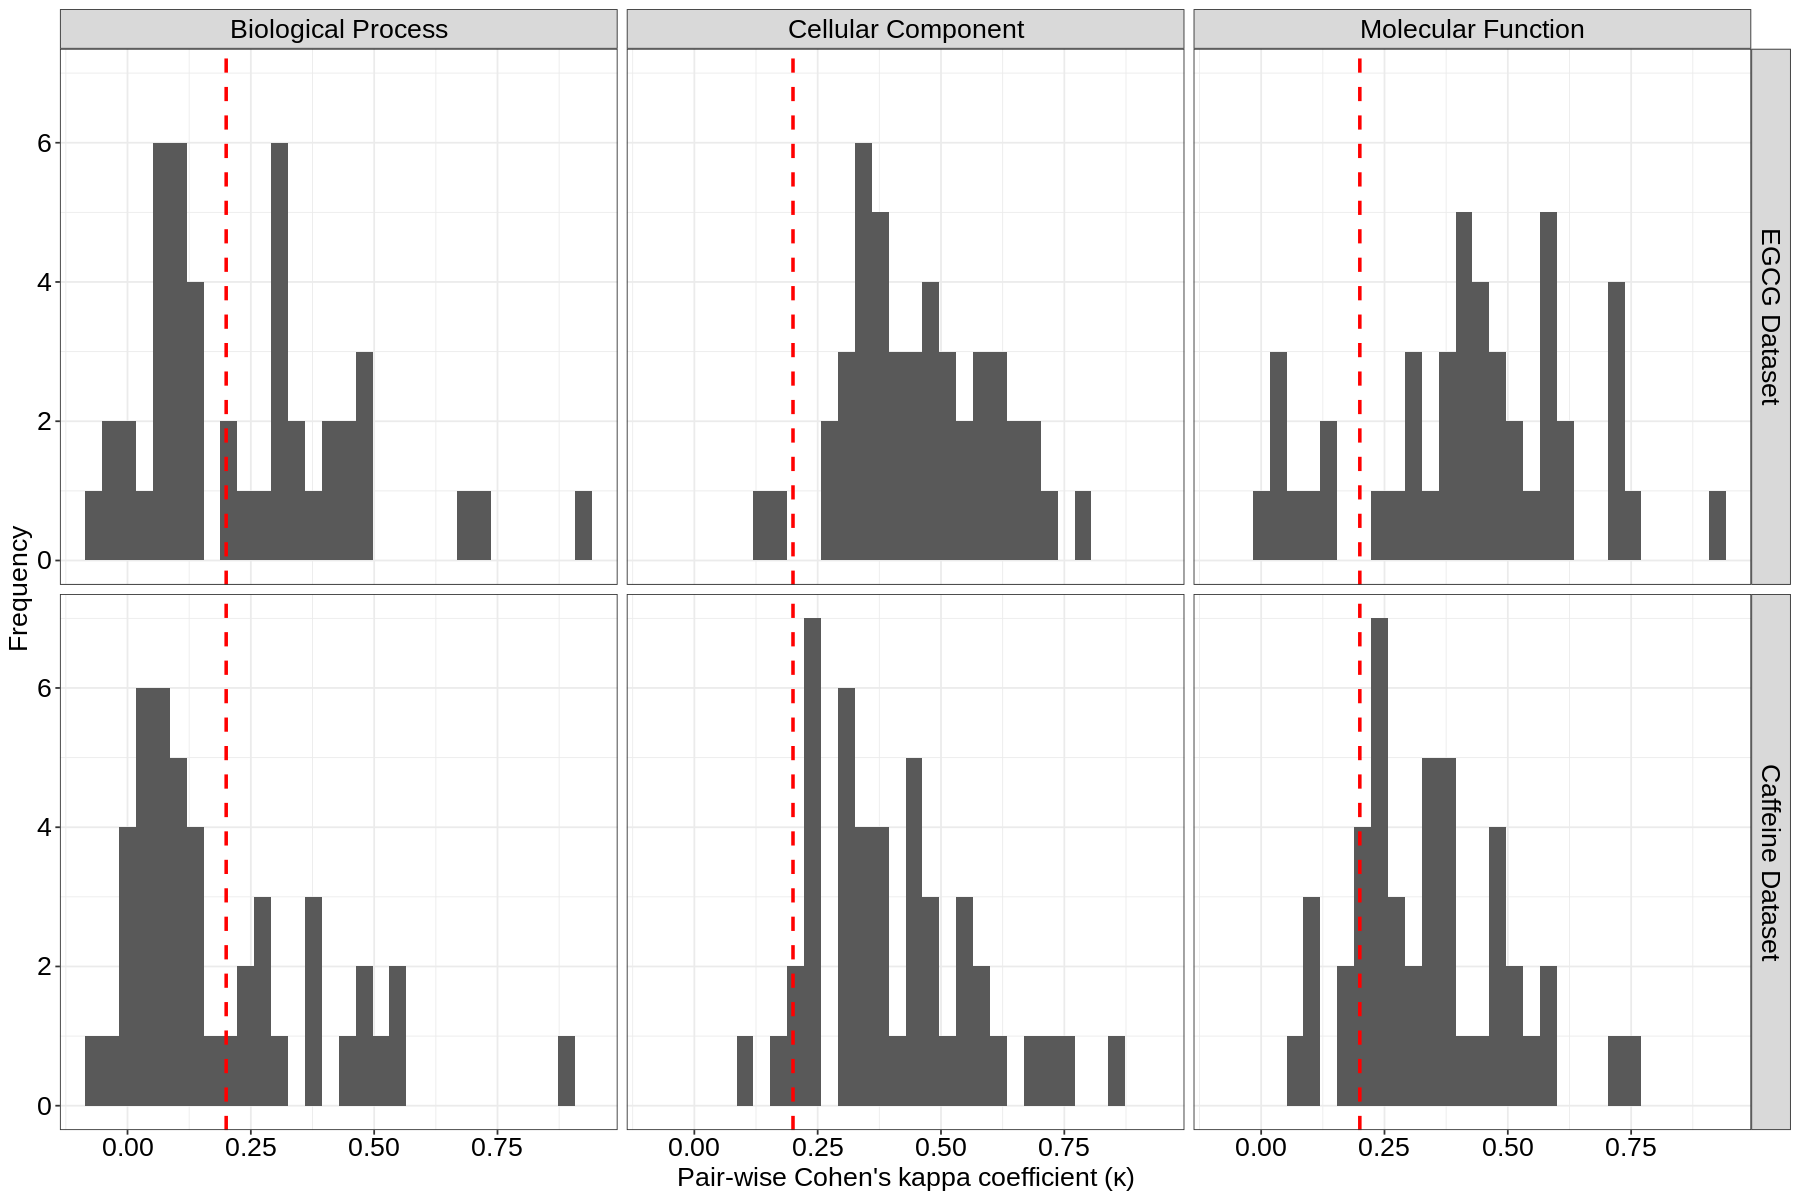

In [ ]:
cdf_validate.02$con_02 <- ifelse(cdf_validate.02$Caffeine < 0.2 & cdf_validate.02$EGCG < 0.2,"Difference","Not difference")
names <- c(`Biological Process` = "Biological Process",
           `Cellular Component` = "Cellular Component",
           `Molecular Function`="Molecular Function",
           Caffeine = "Caffeine Dataset",
           EGCG = "EGCG Dataset")

cdf_validate.02%>% melt() %>% 
  ggplot(aes(x=value)) +
  geom_histogram() +
  facet_grid(cols=vars(Categories),rows=vars(variable), labeller = as_labeller(names)) +
  geom_vline(xintercept=0.2, linetype="dashed", color = "red",size=1) +
  theme_bw() +
  xlab("Pair-wise Cohen's kappa coefficient (κ)")+
  ylab("Frequency")+ guides(color = FALSE) +
  font_custom.02

#Information Content

## summary of GO term IC

In [15]:
all_IC <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-gene) %>% unique() 
head(all_IC)

id,fdr,ref,des,type,dataset,database,condition
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
GO:0008426,0.00475653,18483,protein kinase C inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
GO:0004347,0.04792210,18483,glucose-6-phosphate isomerase activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
GO:0061656,0.04792210,18483,SUMO conjugating enzyme activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
GO:0070320,0.04792210,18483,inward rectifier potassium channel inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
GO:1904851,0.04075850,18883,positive regulation of establishment of protein localization to telomere,Biological Process,Caffeine Dataset,GENECODIS,Unique
GO:1904871,0.04265340,18883,positive regulation of protein localization to Cajal body,Biological Process,Caffeine Dataset,GENECODIS,Unique


In [16]:
P <- toTable(GOBPOFFSPRING)
names(P) <- c("child","parent")
P_count <- as.data.frame(table(P$parent))
P_count$type <- "BP"

C <- toTable(GOCCOFFSPRING)
names(C) <- c("child","parent")
C_count <- as.data.frame(table(C$parent))
C_count$type <- "CC"

M <- toTable(GOMFOFFSPRING) 
names(M) <- c("child","parent") 
M_count <- as.data.frame(table(M$parent))
M_count$type <- "MF"

ref <- rbind(M_count,C_count,P_count)


IC <- function(id,onto){
  cnt <- dplyr::filter(ref, Var1 == i) %>% dplyr::select(Freq) %>% as.numeric()
  df <- AnnotationDbi::select(GO.db, keys(GO.db, "GOID"),  columns = c("ONTOLOGY"))
  df_02 <- as.data.frame(table(df$ONTOLOGY)) %>% dplyr::filter(.,Var1 == onto) 
  all_onto <- as.numeric(df_02[,2])
  if (is.na(cnt) == T) {
    #all GO term in select ontology
    prob <- 1/all_onto
    IC <- -log2(prob)
    return(IC)
  } else {
   prob <- (cnt+1)/all_onto
    IC <- -log2(prob)
    return(IC)
  }
}

In [ ]:
list <- all_IC %>% dplyr::filter(type == "Molecular Function") %>% dplyr::select(id) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"MF")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_MF <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")
names(big_data_MF) <- c("IC","id")


In [ ]:
list <- all_IC %>% dplyr::filter(type == "Cellular Component") %>% dplyr::select(id) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"CC")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_CC <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")  
names(big_data_CC) <- c("IC","id")

In [ ]:
list <- all_IC %>% dplyr::filter(type == "Biological Process") %>% dplyr::select(id) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"BP")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_BP <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")
names(big_data_BP) <- c("IC","id")

In [20]:
names(big_data_BP) <- c("IC","id")
names(big_data_CC) <- c("IC","id")
names(big_data_MF) <- c("IC","id")
IC <- rbind(big_data_BP,big_data_CC,big_data_MF) %>% setnames(c("IC","id"),c("IC","id"))

merge_01 <- inner_join(all_IC,IC,by= "id")
merge_01$IC <- as.numeric(merge_01$IC)
merge_02 <- merge_01 %>% setnames("IC","Information_Content")

merge_EGCG <- merge_02 %>%
  group_by(database,type,dataset) %>% 
  dplyr::summarize(median(Information_Content)) %>% 
  as.data.frame() %>% 
  filter(.,dataset == "EGCG Dataset")

merge_Caffeine <- merge_02  %>%
  group_by(database,type,dataset) %>% 
  dplyr::summarize(median(Information_Content)) %>% 
  as.data.frame() %>% 
  filter(.,dataset == "Caffeine Dataset")

`summarise()` regrouping output by 'database', 'type' (override with `.groups` argument)

`summarise()` regrouping output by 'database', 'type' (override with `.groups` argument)



In [21]:
IC_sum <-cbind(merge_Caffeine,merge_EGCG) 
IC_sum_02 <- IC_sum[,c(1,3,4,6,8)]
names(IC_sum_02) <- c("database","dataset","Caffeine","type","EGCG")
IC_sum_02$cat <- "IC median"
IC_all <- IC_sum_02[,-2]
IC_all

database,Caffeine,type,EGCG,cat
<chr>,<dbl>,<chr>,<dbl>,<chr>
BiNGO,7.572725,Biological Process,9.635102,IC median
BiNGO,5.952838,Cellular Component,6.695802,IC median
BiNGO,8.985066,Molecular Function,10.455857,IC median
ClueGO,11.858127,Biological Process,11.036903,IC median
ClueGO,9.451898,Cellular Component,10.451898,IC median
ClueGO,11.444497,Molecular Function,13.444497,IC median
DAVID,10.858127,Biological Process,7.600739,IC median
DAVID,8.083415,Cellular Component,5.627569,IC median
DAVID,13.444497,Molecular Function,10.274572,IC median


## IC Visualization

In [30]:
EGCG_cor <- reshape(merge_EGCG[,-3],idvar = c("database"),timevar = "type",direction = "wide")
names(EGCG_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
      
EGCG_cor.01 <- EGCG_cor[,-1]
rownames(EGCG_cor.01) <- EGCG_cor[,1]
EGCG_cor.01$BP <- scale(EGCG_cor.01$`Biological Process`)
EGCG_cor.01$MF <- scale(EGCG_cor.01$`Molecular Function`)
EGCG_cor.01$CC <- scale(EGCG_cor.01$`Cellular Component`)

EGCG_cor.02 <- EGCG_cor.01[,-c(1:3)]

row_dend = hclust(dist(EGCG_cor.02),method = "complete") # row clustering
col_dend = hclust(dist(t(EGCG_cor.02)),method = "complete") # column clustering

#row.names(EGCG_cor.02) <- factor(row.names(EGCG_cor.02), levels=c("PANTHER","g:Profiler","GO::TermFinder",
#                                                    "BiNGO","GOstat","STRING","ClueGO",
#                                                    "GENECODIS","DAVID","WebGestalt"))


In [31]:
#EGCG
col_fun = colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))
col_fun(seq(-2, 2))

EGCG_cor <- reshape(merge_EGCG[,-3],idvar = c("database"),timevar = "type",direction = "wide")
names(EGCG_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
      
EGCG_cor.01 <- EGCG_cor[,-1]
rownames(EGCG_cor.01) <- EGCG_cor[,1]
summary(EGCG_cor.01)
EGCG_cor.01$BP <- scale(EGCG_cor.01$`Biological Process`)
EGCG_cor.01$MF <- scale(EGCG_cor.01$`Molecular Function`)
EGCG_cor.01$CC <- scale(EGCG_cor.01$`Cellular Component`)

EGCG_cor.02 <- EGCG_cor.01[,-c(1:3)]

row_dend = hclust(dist(EGCG_cor.02),method = "complete") # row clustering
col_dend = hclust(dist(t(EGCG_cor.02)),method = "complete") # column clustering

options(repr.plot.width=10, repr.plot.height=8)
col_fun = colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))
#col_fun(seq(-2, 2))

Heatmap(EGCG_cor.02,col=col_fun, name = "IC standardized Median", 
        row_names_gp = gpar(fontsize = 13),
        heatmap_legend_param = list(
          legend_height = unit(4, "cm"),
          grid_width = unit(0.5, "cm"),
         title_gp = gpar(fontsize = 13),
         labels_gp = gpar(fontsize = 13)),
        row_dend_width = unit(3, "cm"), 
       cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2f", EGCG_cor.02[i, j]), x, y, gp = gpar(fontsize = 13))
        }, clustering_method_rows = "average",
        cluster_columns = FALSE)


ERROR: ignored

In [33]:
#Caffeine
Caf_cor <- reshape(merge_Caffeine[,-3],idvar = c("Database"),timevar = "Type",direction = "wide")
names(Caf_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
Caf_cor.01 <- Caf_cor[,-1]
rownames(Caf_cor.01) <- Caf_cor[,1]
head(merge_02)
summary(Caf_cor.01)
Caf_cor.01$BP <- scale(Caf_cor.01$`Biological Process`)
Caf_cor.01$MF <- scale(Caf_cor.01$`Molecular Function`)
Caf_cor.01$CC <- scale(Caf_cor.01$`Cellular Component`)

Caf_cor.02 <- Caf_cor.01[,-c(1:3)]

row_dend = hclust(dist(Caf_cor.02),method = "complete") # row clustering
col_dend = hclust(dist(t(Caf_cor.02)),method = "complete") # column clustering

row.names(Caf_cor.02) <- factor(row.names(Caf_cor.02), levels=c("PANTHER","g:Profiler","GO::TermFinder",
                                                    "BiNGO","GOstat","STRING","ClueGO",
                                                    "GENECODIS","DAVID","WebGestalt"))

Heatmap(Caf_cor.02,col=col_fun, name = "IC standardized Median", 
        row_names_gp = gpar(fontsize = 13),
        heatmap_legend_param = list(
          legend_height = unit(4, "cm"),
          grid_width = unit(0.5, "cm"),
         title_gp = gpar(fontsize = 13),
         labels_gp = gpar(fontsize = 13)),
        row_dend_width = unit(3, "cm"),
       cluster_columns = FALSE, 
       cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2f", Caf_cor.02[i, j]), x, y, gp = gpar(fontsize = 13))
        }, clustering_method_rows = "average")

ERROR: ignored

In [ ]:
#Within Dataset
within_IC <- merge_02[,-c(2,3,6,9)]
within_IC_index <- merge_02[,-c(1,2,3,4,6,8,9)] %>% unique()
head(within_IC_index)
head(within_IC)

Type,Dataset
<chr>,<chr>
MF,EGCG
BP,EGCG
CC,EGCG
BP,Caffeine
CC,Caffeine
MF,Caffeine


GOID,Database,Type,Dataset,Information_Content
<chr>,<chr>,<chr>,<chr>,<dbl>
GO:0008301,STRING,MF,EGCG,11.122569
GO:0005544,GOstat,MF,EGCG,13.444497
GO:0035986,GO::TermFinder,BP,EGCG,14.858127
GO:0042886,GO::TermFinder,BP,EGCG,5.646238
GO:0030163,g:Profiler,BP,EGCG,7.688202
GO:0050920,g:Profiler,BP,EGCG,7.963309


In [ ]:
datalist <- list()
for (i in 1:nrow(within_IC_index)) {
all.test.01 <- within_IC %>% filter(.,Type == within_IC_index[i,1] %>% unlist(),
                                      Dataset == within_IC_index[i,2] %>% unlist())
head(all.test.01)
res.aov <- aov(Information_Content ~ Database, data = all.test.01)
model=lm( all.test.01$Information_Content ~ all.test.01$Database )
     ANOVA=aov(model)
TUKEY <- TukeyHSD(x=ANOVA, 'all.test.01$Database', conf.level=0.95) 
TUKEY.02 <- TUKEY$`all.test.01$Database` %>% as.data.frame() %>% select(-diff,-lwr,-upr)
TUKEY.03 <- t(TUKEY.02) %>% as.data.frame()
rownames(TUKEY.03) <- NULL
res <- cbind(tidy(res.aov)[-2,],TUKEY.03)[,-c(1,2,3,4)]
res$Type <- within_IC_index[i,1] %>% unlist()
res$Dataset <-within_IC_index[i,2] %>% unlist()
datalist[[i]] <- res
}

res.01 <- do.call(rbind,datalist) %>% unique()
print(res.01)



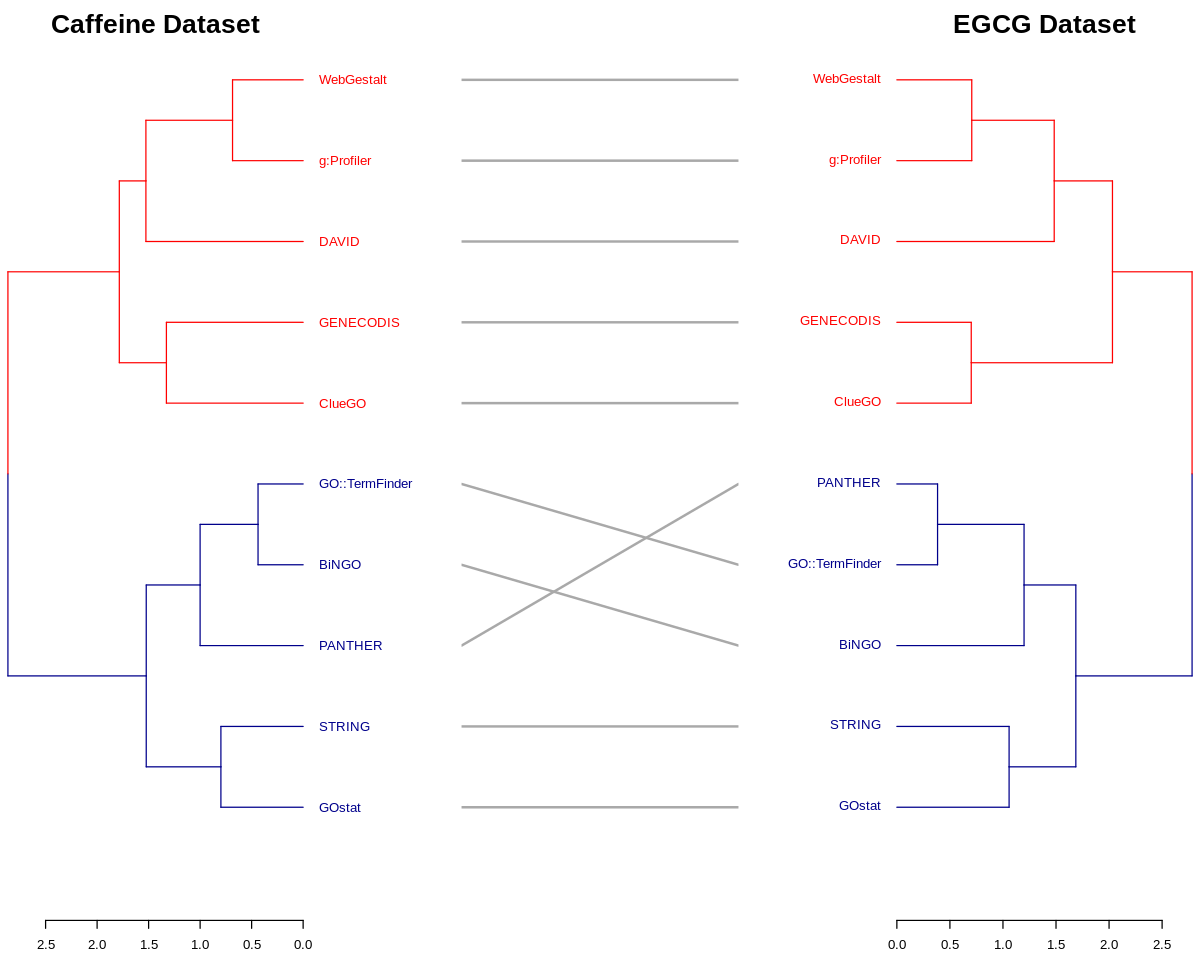

In [ ]:
d1 <- Caf_cor.02 %>% dist() %>% hclust( method="average" ) %>% as.dendrogram()
d2 <- EGCG_cor.02 %>% dist() %>% hclust( method="average" ) %>% as.dendrogram()

# Custom these kendo, and place them in a list
dl <- dendlist(
  d1 %>% 
    set("labels_col", value = c("darkblue", "red"), k=2) %>%
    set("branches_lty", 1) %>%
    set("branches_k_color", value = c("darkblue", "red"), k = 2),
  d2 %>% 
    set("labels_col", value = c("darkblue", "red"), k=2) %>%
    set("branches_lty", 1) %>%
    set("branches_k_color", value = c("darkblue", "red"), k = 2)
)

# Plot them together
tanglegram(dl, 
           common_subtrees_color_lines = FALSE, highlight_distinct_edges  = FALSE, highlight_branches_lwd=FALSE, 
           margin_inner=10,
           lwd=2,
   main_left = "Caffeine Dataset",
   main_right = "EGCG Dataset"
)


# **Rank difference and p-value distribution of identified GO terms**

## summary of GO term p-value

In [22]:
pvalue_tools <- df_01[,c(3,6,7,8)] %>% unique() %>% group_by(type,dataset,database) %>% summarise(MED=median(fdr)) 
pvalue_tools$MED <- -log10(pvalue_tools$MED)
pvalue_Caf <- pvalue_tools %>% filter(dataset == "Caffeine Dataset")
pvalue_EGCG <- pvalue_tools %>% filter(dataset == "EGCG Dataset")
pvalue_all <- cbind(pvalue_Caf,pvalue_EGCG)
pvalue_all_02 <- pvalue_all[,-c(5,6,7)]
names(pvalue_all_02) <- c("type","dataset","database","Caffeine","EGCG")
pvalue_all_02$cat <- "Me p-value"
pvalue_all_final <- pvalue_all_02[,-2]
pvalue_all_final

`summarise()` regrouping output by 'type', 'dataset' (override with `.groups` argument)

New names:
* type -> type...1
* dataset -> dataset...2
* database -> database...3
* MED -> MED...4
* type -> type...5
* ...



type,database,Caffeine,EGCG,cat
<fct>,<fct>,<dbl>,<dbl>,<chr>
Biological Process,BiNGO,1.909707,2.084073,Me p-value
Biological Process,ClueGO,2.470409,2.310357,Me p-value
Biological Process,DAVID,7.253366,5.794525,Me p-value
Biological Process,g:Profiler,5.401209,6.931814,Me p-value
Biological Process,GENECODIS,1.999735,2.115827,Me p-value
Biological Process,GO::TERMFINDER,4.943095,5.266402,Me p-value
Biological Process,GOstat,1.860121,2.316053,Me p-value
Biological Process,PANTHER,3.144093,2.478703,Me p-value
Biological Process,STRING,2.455932,2.247952,Me p-value


## Variation Within Dataset

### F-test plus Pairwise

In [ ]:
Caffeine.test <- all[,-c(2,6)] %>% filter(.,Dataset == "Caffeine") %>% unique() 
EGCG.test <- all[,-c(2,6)] %>% filter(.,Dataset == "EGCG") %>% unique()

all.test <- rbind(Caffeine.test,EGCG.test)[,-c(1,2)] %>% unique()
head(all.test)
all.test.99 <- rbind(Caffeine.test,EGCG.test)
head(all.test.99)

In [ ]:
datalist <- list()
for (i in 1:nrow(all.test)) {
all.test.01 <- all.test.99 %>% filter(.,Type == all.test[i,2] %>% unlist(),
                                            Dataset == all.test[i,3] %>% unlist())
res.aov <- kruskal.test(FDR ~ Database, data = all.test.01)
res.1 <- tidy(res.aov)
res.1$Type <- all.test[i,2] %>% unlist()
res.1$Dataset <-all.test[i,3] %>% unlist()

PT = dunnTest(FDR ~ Database,
              data=all.test.01,
              method="bh")    # Can adjust p-values;
                              # See ?p.adjust for options

PT.02 <- PT$res %>% select(Comparison,P.adj) %>% as.data.frame() 
PT.03 <- PT.02 
rownames(PT.03) <- PT.02[,1]
PT.04 <- t(PT.03) %>% as.data.frame()
rownames(PT.04) <- NULL
res <- cbind(res.1,PT.04[-1,])
datalist[[i]] <- res
}
res.01 <- do.call(rbind,datalist) %>% unique()
head(res.01)

### Display Mean

In [ ]:
me.tools <- all %>% group_by(Dataset,Database,Type) %>% dplyr::summarise(me=median(FDR),sd=sd(FDR)) %>% as.data.frame()
me.tools <- me.tools[order(me.tools$me,me.tools$sd),]
me.tools[,c(4,5)] <- round(me.tools[,c(4,5)], 8)
me.tools[,5] <- round(me.tools[,5], 4)
me.tools[,c(4,5)] <- format(me.tools[,c(4,5)], scientific = T)
me.tools$sumstat <- paste0(me.tools$me," ","(",me.tools$sd,")")

res.me <- reshape(me.tools[,-c(4,5)],idvar = c("Dataset","Type"),timevar = "Database",direction = "wide")
head(res.me)

`summarise()` regrouping output by 'Dataset', 'Database' (override with `.groups` argument)



,Dataset,Type,sumstat.DAVID,sumstat.ClueGO,sumstat.GO::TermFinder,sumstat.PANTHER,sumstat.WebGestalt,sumstat.GOstat,sumstat.STRING,sumstat.BiNGO,sumstat.g:Profiler,sumstat.GENECODIS
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
7,Caffeine,BP,6.0000e-08 (5.80e-03),1.4300e-03 (3.60e-03),7.4800e-06 (5.20e-03),7.3300e-04 (1.36e-02),3.8100e-03 (1.40e-02),1.7700e-02 (1.38e-02),7.3000e-03 (1.46e-02),1.2300e-02 (1.44e-02),3.4200e-03 (1.54e-02),1.6850e-02 (1.67e-02)
37,EGCG,BP,4.2000e-07 (1.30e-02),2.7700e-04 (8.00e-04),8.8500e-04 (1.45e-02),6.3100e-03 (1.40e-02),6.5700e-03 (1.49e-02),3.3700e-02 (1.47e-02),1.5100e-02 (1.33e-02),9.2950e-03 (1.43e-02),1.0700e-02 (1.57e-02),1.4400e-02 (1.47e-02)
36,EGCG,MF,1.0700e-02 (1.30e-02),2.1400e-06 (1.00e-04),1.2100e-02 (1.15e-02),3.1400e-02 (1.66e-02),1.5500e-02 (1.20e-02),1.2350e-02 (1.86e-02),8.1000e-03 (1.69e-02),2.5400e-02 (1.71e-02),8.6100e-03 (1.43e-02),2.9300e-02 (1.60e-02)
5,Caffeine,CC,1.3150e-04 (1.50e-02),1.3370e-05 (1.10e-03),3.3600e-04 (9.40e-03),1.2645e-04 (1.12e-02),2.9400e-04 (1.15e-02),4.1900e-04 (1.48e-02),9.2000e-04 (8.40e-03),1.0350e-03 (1.28e-02),1.9300e-03 (1.54e-02),4.6000e-03 (1.68e-02)
35,EGCG,CC,3.6750e-04 (1.10e-02),1.5950e-05 (5.00e-04),1.1800e-03 (1.20e-02),2.4000e-03 (1.22e-02),4.6500e-03 (1.22e-02),2.8650e-03 (1.68e-02),3.3000e-03 (9.90e-03),5.5000e-03 (1.79e-02),4.7000e-03 (1.48e-02),1.3300e-02 (1.56e-02)
6,Caffeine,MF,8.1800e-03 (1.67e-02),4.0600e-04 (3.60e-03),8.5000e-03 (1.49e-02),1.0850e-02 (1.26e-02),2.2900e-02 (1.75e-02),8.5000e-03 (1.57e-02),1.4300e-02 (1.36e-02),2.1800e-02 (1.37e-02),7.7700e-03 (1.58e-02),2.4600e-02 (1.97e-02)


### Display Plot

In [ ]:
df <- final_all[,-c(4,6,7)] 
names(df) <- c("database","type","EGCG Dataset","Caffeine Dataset")
df_02 <- melt(df,id.vars=c("database","type"))

ggplot(df_02,aes(x=reorder(database,value),y=value,color = type,group = type)) +
  geom_point() +
  geom_line() +
  facet_grid(vars(variable)) +
  theme_bw()+ 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("GO Enrichment Tools") +
  ylab("False Disvoery Rate (Median)") +
  labs(color="")+ 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15))


# Trend

In [ ]:
cdf <- rbind(GO_freq,annotate_gene,uniqueness_GO,IC_all,pvalue_all_final)
cdf$cat %>% unique()

In [24]:
mani_df <- function(j,k){
  cdf <- rbind(GO_freq,annotate_gene,uniqueness_GO,IC_all,pvalue_all_final)%>% filter(cat == j,type == k) 
  cdf_02 <- cdf[,-1]
  rownames(cdf_02) <- cdf[,1]
  sumstat_frq <- cdf_02 %>% filter(cat==j) %>% group_by(type) %>% summarise(Ca=mean(Caffeine),EG=mean(EGCG))
  cdf_02$tools <- ifelse(cdf_02$Caffeine > sumstat_frq$Ca & cdf_02$EGCG > sumstat_frq$EG, "yes",
  ifelse(cdf_02$Caffeine < sumstat_frq$Ca & cdf_02$EGCG < sumstat_frq$EG,"yes",""))
  index_df <- which(cdf_02$tools == "yes") %>% as.vector()
  cdf_02$tool[index_df] <- rownames(cdf_02)[index_df]
  cdf_final <- cdf_02[,-5]
  return(cdf_final)
}


In [25]:
Sum_stat_index <- function(j,k){
  cdf <- rbind(GO_freq,annotate_gene,uniqueness_GO,IC_all,pvalue_all_final)%>% filter(cat == j,type == k) 
  cdf_02 <- cdf[,-1]
  rownames(cdf_02) <- cdf[,1]
  sumstat_frq <- cdf_02 %>% filter(cat==j) %>% group_by(type) %>% mutate(Nor_EGCG = (EGCG-min(EGCG))/(max(EGCG)-min(EGCG)),
                                                Nor_Caffeine = (Caffeine-min(Caffeine))/(max(Caffeine)-min(Caffeine))) %>%
                                                group_by(type) %>% summarise(Me_caf = mean(Nor_Caffeine),Me_EGCG = mean(Nor_EGCG))
                                                  
  return(sumstat_frq)
}

In [26]:
plot_graph <- function(i){
  BP_Freq <- mani_df(i,"Biological Process")
  MF_Freq <- mani_df(i,"Molecular Function")
  CC_Freq <- mani_df(i,"Cellular Component")

  BP_Index <- Sum_stat_index(i,"Biological Process")
  MF_Index <- Sum_stat_index(i,"Molecular Function")
  CC_Index <- Sum_stat_index(i,"Cellular Component")

  all_Freq <- rbind(BP_Freq,MF_Freq,CC_Freq) %>%  group_by(type) %>% mutate(Nor_EGCG = (EGCG-min(EGCG))/(max(EGCG)-min(EGCG)),
                                                Nor_Caffeine = (Caffeine-min(Caffeine))/(max(Caffeine)-min(Caffeine)))

  all_index <- rbind(BP_Index,CC_Index,MF_Index)
  options(repr.plot.width=15, repr.plot.height=6)
  ggplot(all_Freq,aes(Nor_Caffeine,Nor_EGCG)) +
  geom_point(color = ifelse(all_Freq$tool == "", "grey50", "red"),size=3) +
  facet_grid(cols=vars(type)) +
  geom_label_repel(aes(label = tool),
                     box.padding   = 0.65, 
                     point.padding = 0.35,
                    segment.color = 'grey50')+ 
   geom_vline(data = all_index[,c("type","Me_caf")], aes(xintercept = Me_caf),linetype = 2,color="grey") +
   geom_hline(data = all_index[,c("type","Me_EGCG")], aes(yintercept = Me_EGCG),linetype = 2,color="grey") +
   font_custom +
   theme_bw() +
   xlab("Caffeine Dataset") +
   ylab("EGCG Dataset")

}


#Plot


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



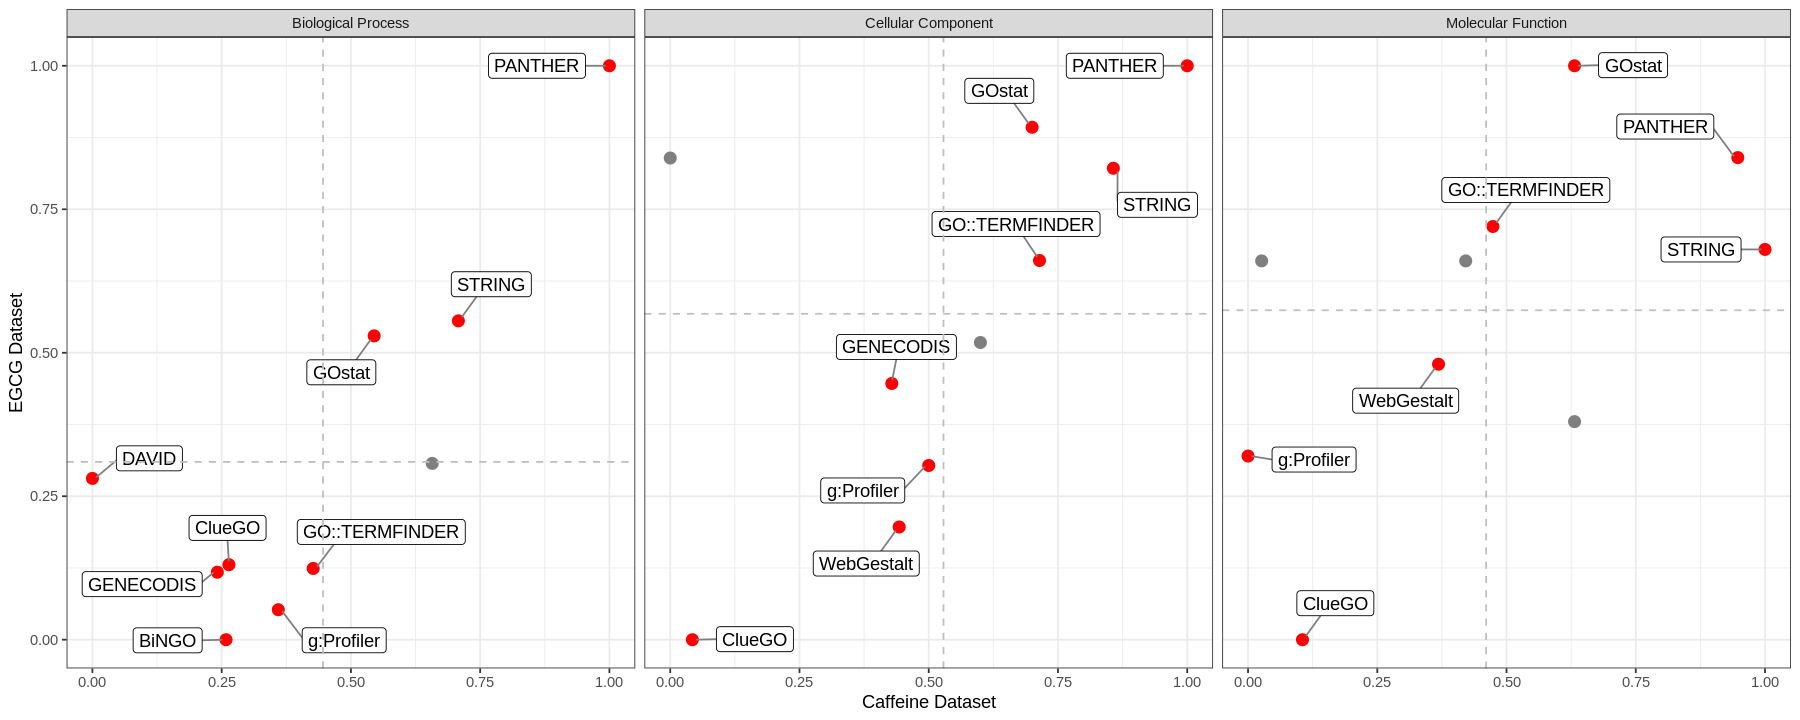

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



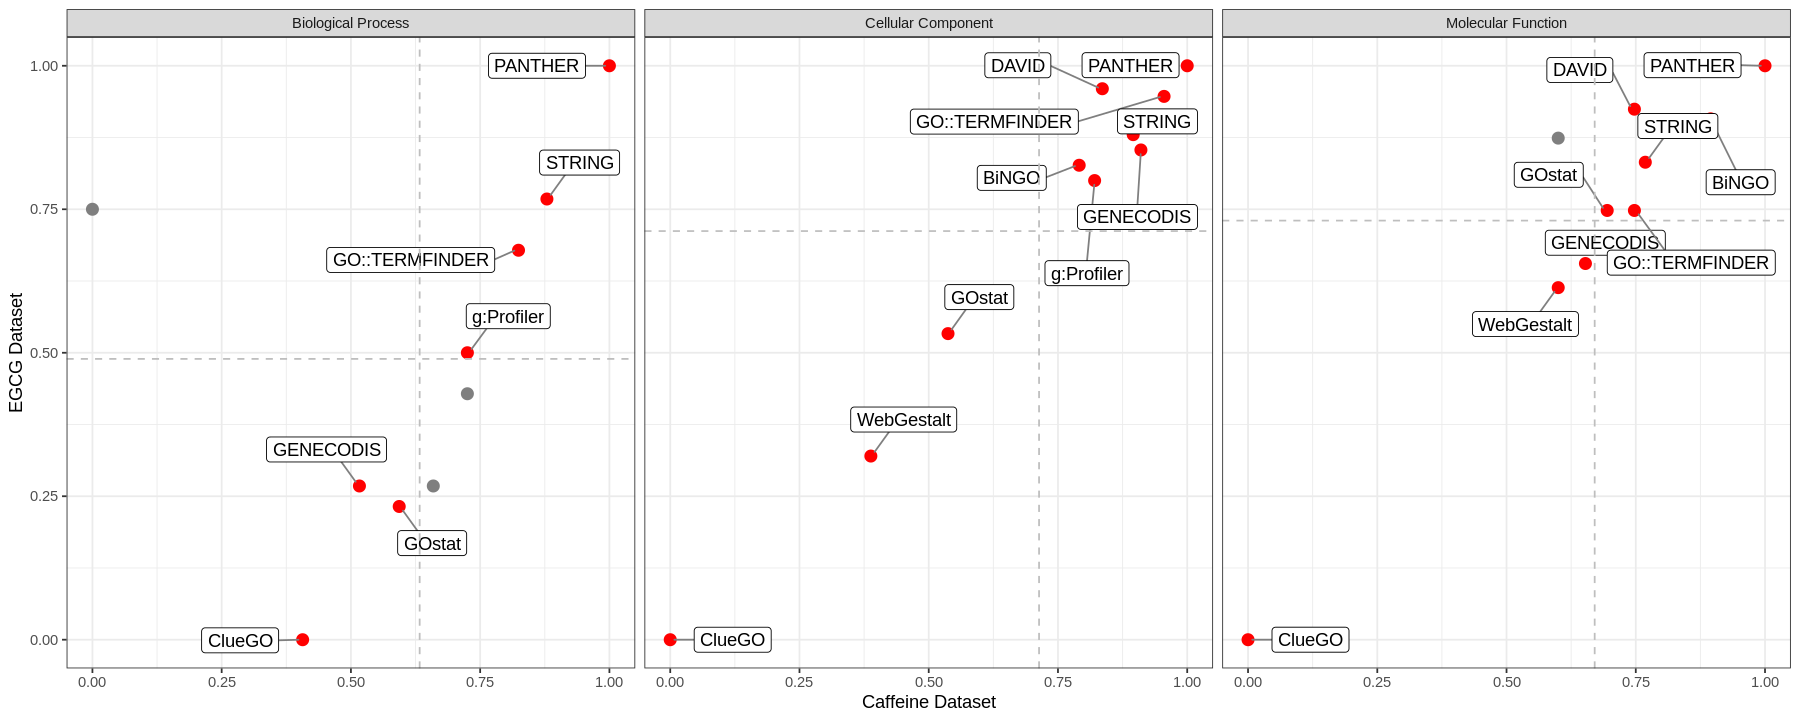

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



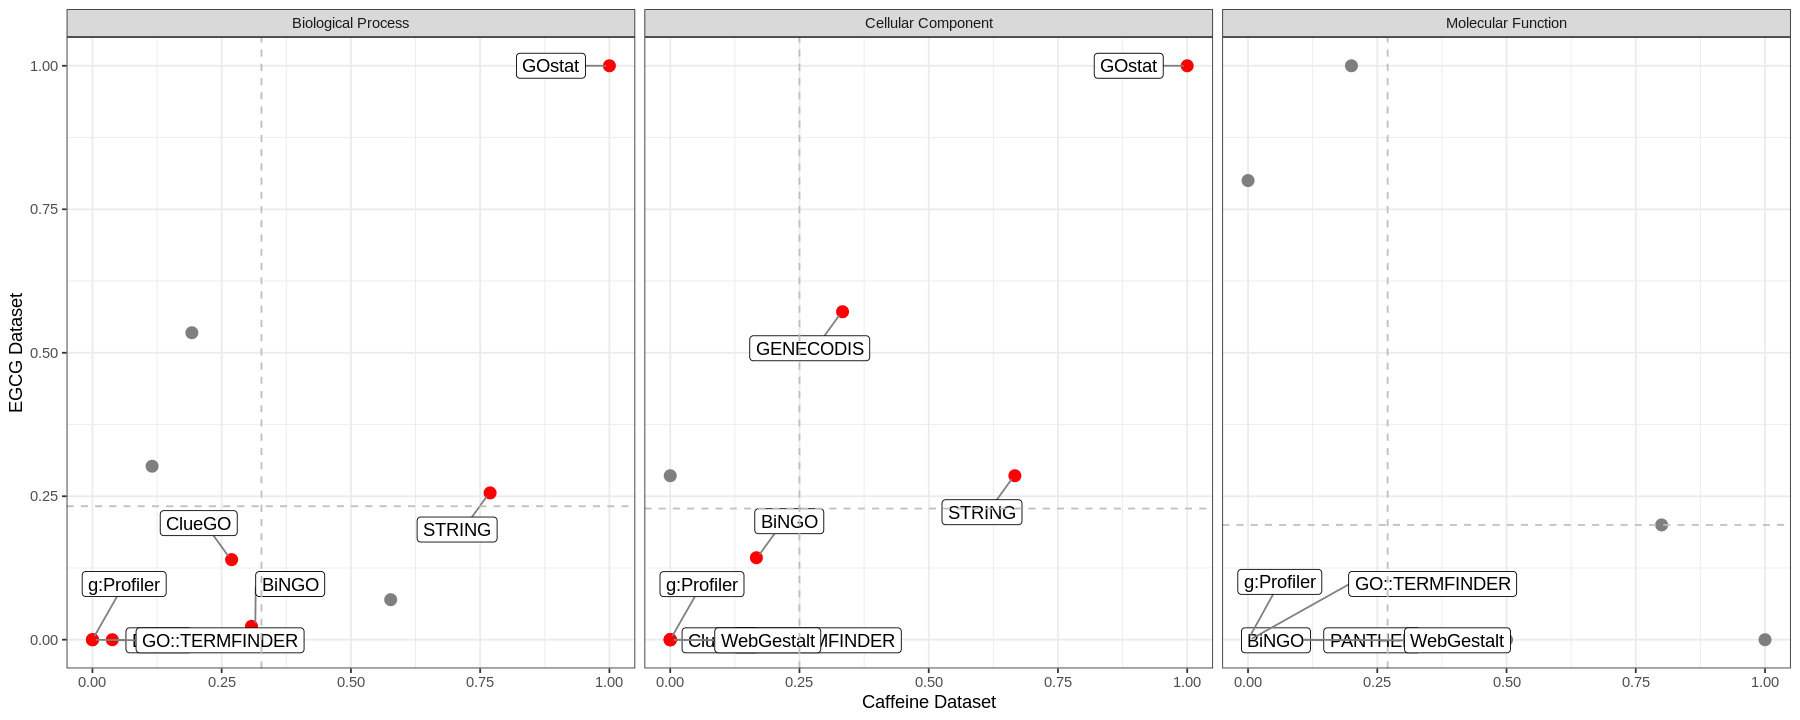

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



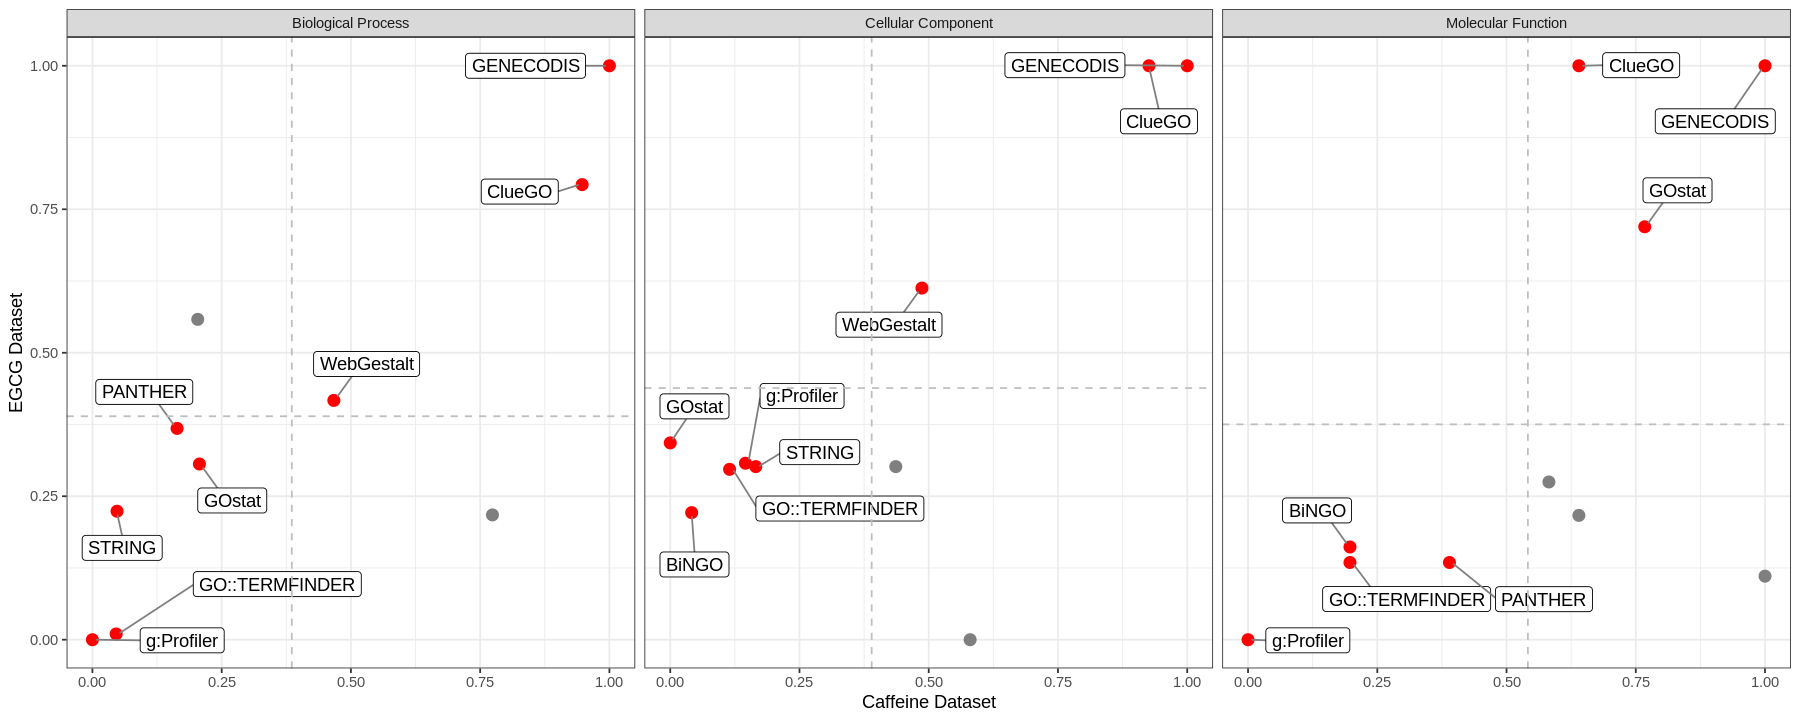

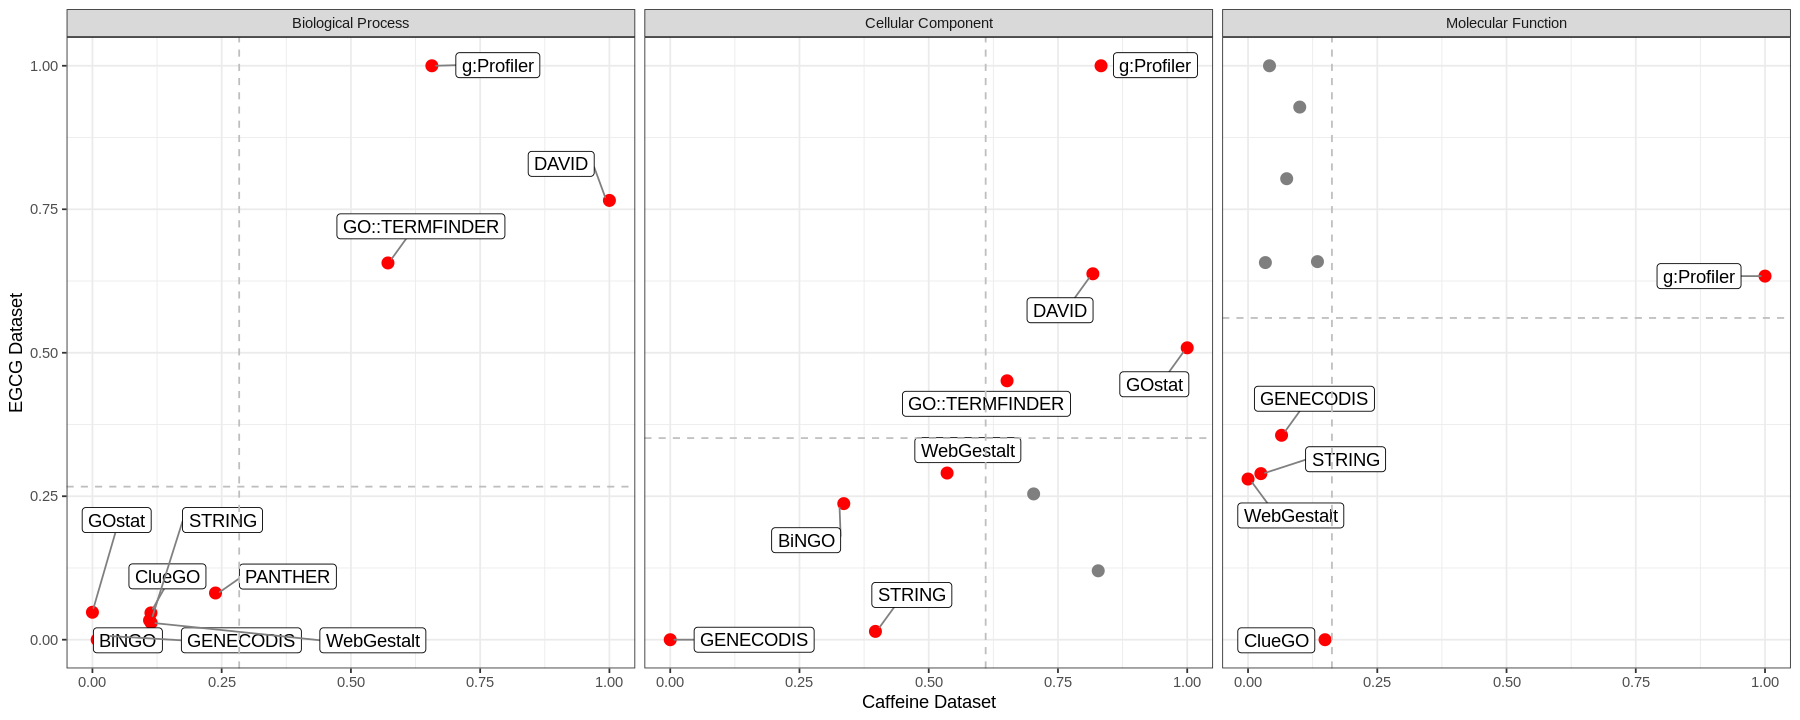

In [29]:
plot_graph("Freq")
plot_graph("Annotated Gene")
plot_graph("Uniquess")
plot_graph("IC median")
plot_graph("Me p-value")